Welcome to you for the best kernel of this competition. Coded by me Sémi Ben Hsan (SBH) .Freelance Machine Learning Engineer. This kernel includes all the advanced techniques of Time Series Forecasting , programmed in a professional way ( The SBH style ) and explained in detail . I AM WAITING FOR YOUR VOTES , opinions and comments ... The strength of this work is that it is generic and can be extended for any Time Series problem Also these codes are original and do not exist in any github repo / Kaggle notebook / blog . on the internet . They are totally produced by the author with the help of God and his own creativity. So If you use parts of this notebook in your scripts/notebooks, giving some kind of credit would be very much appreciated :) You can for instance link back to this notebook. Thanks!



0. Downloading Datasets
1. Imports & Install 
2. EDA
3. Auto Arima
4. Prophet
5. LSTM
6. DeepAR
7. Isolation forest for Anomaly Detection 
8. Auto Encoder for Anomaly Detection
9. AutoML 
10. Reinforcement Learning Approches
11. Classic Machine learning Approches

	11.1 Utils

	11.2 Filling_Nans

	11.3 Preprocess

	11.4  GridSearchCV

	11.5 Optuna Framework

	11.6 KFold
  
12.Graph Neural Networks

13. Apach Spark


In order to give the readers a variation in the data set and at the same time give them a useful source of time series datasets. For the different approaches we will use different data sets depending on what the author sees fit. Enjoy your reading .. 

0. Downloading Dataset

In [1]:
!pip install download
!pip install fbprophet
from download import download
import pandas as pd
path = download('https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip', '/tmp/aq', kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 7.96M/7.96M [00:00<00:00, 30.1MB/s]
Extracting zip file...
Successfully downloaded / unzipped to /tmp/aq


convert_to_date(x) : Function that takes a list of columns 
hour , minute , day , year and concatenate them into a single column this function will be passed as an argument to pd.read_csv( )(date_parser=convert_to_date) 
parse_dates = [['year', 'month', 'day', 'hour']] will be the list of columns passed as argument for convert_to_date .. An automatic column with the name 'year_month_day_hour' will be added to the data set

In [2]:
from datetime import datetime
def convert_to_date(x): 
	return datetime.strptime(x, '%Y %m %d %H')

In [3]:
df = pd.read_csv('/tmp/aq/PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv', parse_dates = [['year', 'month', 'day', 'hour']],date_parser=convert_to_date, keep_date_col=True)

In [4]:
df.head()

year_month_day_hour  No  year month day hour  PM2.5  PM10  SO2  NO2     CO  \
0 2013-03-01 00:00:00   1  2013     3   1    0    4.0   4.0  3.0  NaN  200.0   
1 2013-03-01 01:00:00   2  2013     3   1    1    7.0   7.0  3.0  NaN  200.0   
2 2013-03-01 02:00:00   3  2013     3   1    2    5.0   5.0  3.0  2.0  200.0   
3 2013-03-01 03:00:00   4  2013     3   1    3    6.0   6.0  3.0  NaN  200.0   
4 2013-03-01 04:00:00   5  2013     3   1    4    5.0   5.0  3.0  NaN  200.0   

     O3  TEMP    PRES  DEWP  RAIN   wd  WSPM   station  
0  82.0  -2.3  1020.8 -19.7   0.0    E   0.5  Dingling  
1  80.0  -2.5  1021.3 -19.0   0.0  ENE   0.7  Dingling  
2  79.0  -3.0  1021.3 -19.9   0.0  ENE   0.2  Dingling  
3  79.0  -3.6  1021.8 -19.1   0.0  NNE   1.0  Dingling  
4  81.0  -3.5  1022.3 -19.4   0.0    N   2.1  Dingling

In [5]:
df_holi = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
df_oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
df_stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')
df_trans = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv')

df_train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
df_test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')

1. IMPORTS

Here there is nothing special an import block for all the frameworks that will accompany us in this notebook 

In [6]:
#!pip install --upgrade mxnet-cu101==1.6.0.post0
# !pip install --upgrade mxnet==1.6.0
!pip install gluonts

     |████████████████████████████████| 2.1 MB 916 kB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
aiobotocore 1.4.1 requires botocore<1.20.107,>=1.20.106, but you have botocore 1.21.44 which is incompatible.


In [7]:
%matplotlib inline
import plotly.express as px
import seaborn as sns
import pandas_profiling
import statsmodels.api as sm
import statsmodels.tsa.stattools as sm
from statsmodels.tsa.stattools import kpss ,  adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gluonts
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
import matplotlib.pyplot  as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
from fbprophet.plot import add_changepoints_to_plot
# from keras.preprocessing.sequence import TimeseriesGenerator

2021-10-12 14:48:39.261028: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-12 14:48:39.261162: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
!pip3 install auto-ts
!pip install tscv
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import plotly.express as px
# from auto_ts import auto_timeseries

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

     |████████████████████████████████| 90 kB 1.0 MB/s 
     |████████████████████████████████| 1.4 MB 1.9 MB/s 
     |████████████████████████████████| 23.1 MB 70.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0 which is incompatible.


In [9]:
# Gym stuff
# !pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym
# import gym
# import gym_anytrading
# # Stable baselines - rl stuff
# # from stable_baselines.common.vec_env import DummyVecEnv
# from stable_baselines import A2C

2. EDA

Class EDA : 

Will be useful for everything related to Time Series exploration. Here you will find all the functions you will need which are divided into 9 parts 

   Part 1 : constructor : the class constructor

   Part 2 : Solving Time Series problems : Everything about missing and duplicated values 

   Part 3 : Stats on the Time Serie : Stats of all types offered by pandas and pandas_profiling

   Part 4: Before plotting functions : Processing utilities to adapt the dataset to the plotting framework

   Part 5 : Plotting : Different plots offered here . In order to better visualize statically our data set 

   Part 6 : Correlations : To study the correlation between the different features of the data set and the outliers 

   Part 7 : Seasonality Tests : Hypothesis tests to check if the time series is stationary 

   Part 8 : TS Decomposition : Containing useful functions to decompose the Time Series into different components 

   Part 9 : Other Functions : Containing useful functions to make different calculations 


eda = EDA(df) : The Constructor of the class .. Only take the data frame df that you want 

eda.duplicate_values() :     Eliminate the duplicated values from the data frame 

eda.duplicate_indices() :Check whether the indices have any duplicates : return DataFrame

eda.missing_values_df() : Checks missing values :return DataFrame

eda.missing_values_columns() : Check whether there is missing value in a given column 

eda.fill_na() : There will be a bunch of different methods .. like .fillna(''ffill'')  etc ... So will make it empty for now 
bcz it will be based on the nature of the problem 

eda.summary() :   Return summary/describe of DataFrame :return DataFrame

eda.pandas_profiling() :  There summary stats with pandas profiling framework

eda.column_convert() : Convert string column to numerical one

eda.set_index (column) : This will serve to set column as  index it is very useful for many frameworks in order to get some plots

eda.plot_column(column)  :This will be useful to plot a particular column in the data set

eda.express_plot (x_column,y_column,title) : This will serve to make a plot of y_columns with respect to x_column with plotly.express

eda.lag_plot(column,lag) : This will serve to plot T(t) with respect to T(t+lag) of a given column 

eda.pair_plot(columns) : This will serve to plot the correlation between several columns 

eda.autocorrelation_plot(column): Autocorrelation plot for time series. The horizontal lines in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band.

eda.corr_heatmap(): This will serve to plot the correlation matrix between the features of the data set 

eda.outliers(column) : This will help extract the outliers from a column 

eda.kpss_test(column) : Perform the Kpss test in order the know if the serie is stationnary or not 

eda.adfuller_test(column) : Perform the adfuller test in order the know if the serie is stationnary or not 

eda.plot_time_series_seasonal_decomp(column, model='additive') : This will perform TS decompostion into different compononts 

eda.plot_composants(column,res) :This will help to plot to plot the several compononts of TS 

eliminate_composant (res,composant) : This will eliminate the componont you want from the time serie 

eda.resampling(freq): This will help to sample some observation with a fixed frequency 

eda.difference(freq) : Every observation will get its current value minus the observation situated by freq lines before it

eda.shifting(freq) : Every datetime will be shifted by a frequency freq

eda.rolling(window) :  Make some operations on data frame .sum() .medium() etc ... 

eda.group(freq) : Make some grouppement operations on the data frame 

eda.cummulative_sum(column) : Calculate the cummulative_sum on a column 

eda.pourcentage_change(column,freq) : Calculate the pourcentage change between two obsevations distant with freq lines 

In [10]:
class EDA():
  # Part 1 : constructor
  def __init__(self, df): 

    '''
    The Constructor of the class .. Only take the data frame df that you want 

    '''

    self.df = df
    
  # Part 2 : Solving Time Series problems
  def duplicate_values(self): 

    ''' 
    Eliminate the duplicated values from the data frame 

    '''
    duplicates = self.df[self.df.duplicated(subset=None, keep='first')==True]
    print("Duplicate values data")
    return duplicates

   # Part 3 : Stats on the Time Serie
  def duplicate_indices(self): 
        '''
        Check whether the indices have any duplicates
        
        :return DataFrame

        '''        
        duplicate_indices = self.df[self.df.index.duplicated()==True]
        
        print("Duplicate indices")
        
        return duplicate_indices
   
   
  def missing_values_df(self):

        """
        Checks missing values
        
        :return DataFrame
        
        """
        missing = self.df[self.df.isna().any(axis=1)]
        
        print("Missing values data")
        
        return missing

  def missing_values_columns (self,column) : 

    """check whether there is missing value in a given column"""

    missing = self.df.query(column + ' != ' + column ) 
    print ('Missing value in ', column)
    return missing

  def fill_na(self) : 

    """There will be a bunch of different methods .. like .fillna(''ffill'')  etc ... So will make it empty for now 
    bcz it will be based on the nature of the problem """

    pass 
 
  # Part 4: Before plotting functions 
  def summary(self): 

        """
        Return summary/describe of DataFrame
        
        :return DataFrame
        """       
        summary = self.df.reset_index().describe(include='all').transpose()
        
        print("Summary metrics")
        
        return summary

  def pandas_profiling(self):

    """There summary stats with pandas profiling framework"""

    self.df.profile_report(style={'full_width':True})  

  # Partie 4 : Before plotting 

  def column_convert(self,column) : 

    """ Convert string column to numerical one """

    self.df[column]=pd.to_numeric(self.df[column])

  def set_index (self,column) :

    """This will serve to set column as  index it is very useful for many frameworks in order to get some plots"""

    self.df = self.df.set_index(column)
    

  # Partie 5 : Plotting 
  def plot_column (self,column) : 

    """This will be useful to plot a particular column in the data set"""

    self.df[column].plot(grid=True) 
    plt.show()

  def express_plot (self,x_column,y_column,title): 

    """ 
    This will serve to make a plot of y_columns with respect to x_column with plotly.express 

    """
    fig = px.line(self.df, x=x_column, y=y_column, title=title)
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=2, label="2y", step="year", stepmode="backward"),
                dict(count=3, label="3y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    fig.show()
  def lag_plot (self,column,lag) :

    """ 
    This will serve to plot T(t) with respect to T(t+lag) of a given column 
    """
    pd.plotting.lag_plot(self.df[column],lag=lag)
  def pair_plot (self,columns) :  

    """ 
    This will serve to plot the correlation between several columns 

    """

    return sns.pairplot(self.df[columns])
  def autocorrelation_plot (self,column) : 

    """ 
    Autocorrelation plot for time series.

    The horizontal lines in the plot correspond to 95% and 99% confidence bands.

    The dashed line is 99% confidence band.
    """

    return pd.plotting.autocorrelation_plot(self.df[column])

  # Partie 6 : Correlations 
  def corr_heatmap(self):

    """ 
    This will serve to plot the correlation matrix between the features of the data set 
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    corr = self.df.corr()
    hm = sns.heatmap(round(corr,2), annot=True, cmap="coolwarm",fmt='.2f', linewidths=.05)
    fig.subplots_adjust(top=0.93)
    title = fig.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)
    return plt.show() 

  def outliers(self, column):

        ''' 
        Checks outliers - anything outside of 5% to 95% quartile range
        
        :param col : str
            Name of col to be tested
            
        :return DataFrame
        '''
        outliers = self.df[~self.df[column].between(self.df[column].quantile(.05), self.df[column].quantile(.95))]
        
        print("Outliers")
        
        return outliers

  # Partie 7 : Seasonality Tests 
     
  def kpss_test(self,column,regression = 'c'):   

    """
    Perform the Kpss test in order the know if the serie is stationnary or not 
    """
    stats, p, lags, critical_values = kpss(self.df[column], regression = regression)
    print(f'Test Statistics: {stats}')
    print(f'Test Statistics: {stats}')
    print(f'p-value: {p}')
    print(f'Critial Values: {critical_values}')
    if p < 0.05 :
      print('Series is not Stationary') 
    else:
      print('Series is Stationary')
  def adfuller_test (self,column) : 

    """ 
     Perform the adfuller test in order the know if the serie is stationnary or not 

     """
    result = adfuller(self.df[column])
    print(f'Test Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critial Values: {result[4]}')
    if result[1] > 0.05 :
      print('Series is not Stationary')
    else:
      print('Series is Stationary')
  

  # Partie 8 : TS Decomposition
  def plot_time_series_seasonal_decomp(self,column, model='additive'):

    """
     This will perform TS decompostion into different compononts 
     """

    res = sm.tsa.seasonal_decompose(self.df[column],model=model)
    resplot = res.plot()
    return res 
  def plot_composants (self,column,res) : 

    """ 
    This will help to plot to plot the several compononts of TS 
    """
    plt.figure(figsize=(22,7))
    plt.title('Trend plot')
    res.trend.plot()
    plt.figure(figsize=(22,7))
    plt.title('Residual plot')
    res.resid.plot()
    plt.figure(figsize=(22,7))
    plt.title('Seasonal plot')
    res.seasonal.plot()
  def eliminate_composant (self,res,composant) :  

    """ 
    This will eliminate the componont you want from the time serie 
    """
    if composant == 'trend' : 
      pd.DataFrame(res.observed/res.trend).plot()
    elif composant == 'resid' : 
      pd.DataFrame(res.observed/res.resid).plot()
    elif composant == 'seasonal' : 
      pd.DataFrame(res.observed/res.seasonal).plot()
    else : 
      print ("error")
  # Partie 9 : Other Functions 
  def resampling(self,freq) : 

    """ 
    This will help to sample some observation with a fixed frequency 
    """
    return self.df.resample(freq).mean() 
  def difference (self,freq,column) : 

    """
    Every observation will get its current value minus the observation situated by freq lines before it 

    """
    return self.df[column].diff(freq)

  def shifting (self,freq) :  

    """
    This will shift the observations by a frequency freq 
    """ 

    return self.df.shift(freq)
  def tshifting (self,freq) : 

    """ 
        This will shift the dates by a frequency freq 
    """

    return self.df.tshift(2)

  def rolling (self,window) : 

    """ 
    Make some operations on data frame .sum() .medium() etc ... 
    """ 
    return self.df.rolling(window=window).sum() 
  def group (self,freq) : 

    if freq == "weekly" : 
      return self.df.groupby(self.df.index.dayofweek).mean() 
    elif freq == "monthly" : 
      return self.df.groupby(self.df.index.month).mean()  
    elif freq == "yearly" : 
      return self.df.groupby(self.df.index.year).mean()  
    else : 
      print ("eurror")

  def cummulative_sum (self,column) :

    """ 
    Calculate the cummulative_sum on a column 
    """
    return pd.DataFrame(self.df[column].cumsum()) 
  def pourcentage_change (self,column,freq) :  
    
    """ 
     Calculate the pourcentage change between two obsevations distant with freq lines
     """
    return self.df[column].pct_change(freq)  

In [11]:
eda = EDA(df)
eda.df.fillna(5,inplace=True) # Fill with whatever you want .. here just a demonstration


In [12]:
eda.duplicate_values()


Duplicate values data


Empty DataFrame
Columns: [year_month_day_hour, No, year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, wd, WSPM, station]
Index: []

In [13]:
eda.duplicate_indices()


Duplicate indices


Empty DataFrame
Columns: [year_month_day_hour, No, year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, wd, WSPM, station]
Index: []

In [14]:
eda.missing_values_df() 


Missing values data


Empty DataFrame
Columns: [year_month_day_hour, No, year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, wd, WSPM, station]
Index: []

In [15]:
eda.missing_values_columns('PM10') 


Missing value in  PM10


Empty DataFrame
Columns: [year_month_day_hour, No, year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, wd, WSPM, station]
Index: []

In [16]:
eda.summary()


Summary metrics


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


count unique                  top   freq      first  \
index                35064.0    NaN                  NaN    NaN        NaT   
year_month_day_hour    35064  35064  2013-03-01 00:00:00      1 2013-03-01   
No                   35064.0    NaN                  NaN    NaN        NaT   
year                   35064      5                 2016   8784        NaT   
month                  35064     12                    3   2976        NaT   
day                    35064     31                    1   1152        NaT   
hour                   35064     24                    0   1461        NaT   
PM2.5                35064.0    NaN                  NaN    NaN        NaT   
PM10                 35064.0    NaN                  NaN    NaN        NaT   
SO2                  35064.0    NaN                  NaN    NaN        NaT   
NO2                  35064.0    NaN                  NaN    NaN        NaT   
CO                   35064.0    NaN                  NaN    NaN        NaT   
O3                   35064.0    NaN                  NaN    NaN        NaT   
TEMP                 35064.0    NaN                  NaN    NaN        NaT   
PRES                 35064.0    NaN                  NaN    NaN        NaT   
DEWP                 35064.0    NaN                  NaN    NaN        NaT   
RAIN                 35064.0    NaN                  NaN    NaN        NaT   
wd                     35064     17                  NNW   4776        NaT   
WSPM                 35064.0    NaN                  NaN    NaN        NaT   
station                35064      1             Dingling  35064        NaT   

                                   last         mean           std     min  \
index                               NaT      17531.5  10122.249256     0.0   
year_month_day_hour 2017-02-28 23:00:00          NaN           NaN     NaN   
No                                  NaT      17532.5  10122.249256     1.0   
year                                NaT          NaN           NaN     NaN   
month                               NaT          NaN           NaN     NaN   
day                                 NaT          NaN           NaN     NaN   
hour                                NaT          NaN           NaN     NaN   
PM2.5                               NaT    64.634523      72.02359     3.0   
PM10                                NaT     82.26661      79.51311     2.0   
SO2                                 NaT    11.609128     15.387066  0.2856   
NO2                                 NaT    26.790621     26.247499  1.0265   
CO                                  NaT   853.259326     901.63343     5.0   
O3                                  NaT    66.348174     54.088006  0.2142   
TEMP                                NaT    13.672982     11.361732   -16.6   
PRES                                NaT  1006.330378      39.19513     5.0   
DEWP                                NaT     1.510777     13.812316   -35.1   
RAIN                                NaT     0.067551      0.775546     0.0   
wd                                  NaT          NaN           NaN     NaN   
WSPM                                NaT     1.857695      1.313628     0.0   
station                             NaT          NaN           NaN     NaN   

                         25%      50%       75%      max  
index                8765.75  17531.5  26297.25  35063.0  
year_month_day_hour      NaN      NaN       NaN      NaN  
No                   8766.75  17532.5  26298.25  35064.0  
year                     NaN      NaN       NaN      NaN  
month                    NaN      NaN       NaN      NaN  
day                      NaN      NaN       NaN      NaN  
hour                     NaN      NaN       NaN      NaN  
PM2.5                   13.0     39.0      91.0    881.0  
PM10                    24.0     58.0     116.0    905.0  
SO2                      2.0      5.0      14.0    156.0  
NO2                      8.0     18.0      37.0    205.0  
CO                     300.0    600.0

In [17]:
# eda.pandas_profiling() # pb pandas pb_profilling 


In [18]:
eda.column_convert('month')


In [19]:
eda.set_index ('year_month_day_hour')

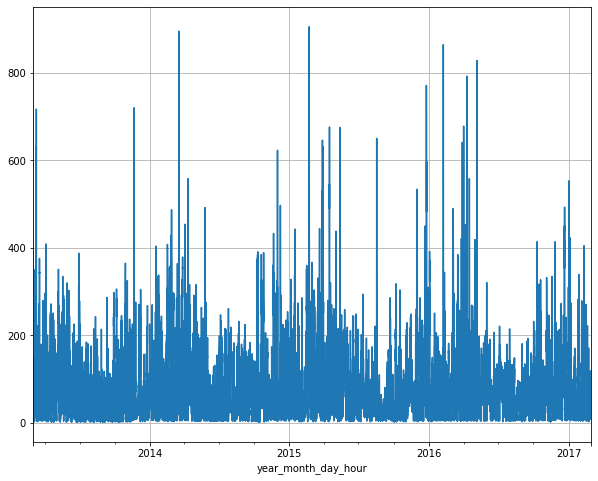

In [20]:
eda.plot_column('PM10')  # index should be date


In [21]:
eda.express_plot ('day','PRES','PRES with respect of year_month_day_hour') # column should be existed


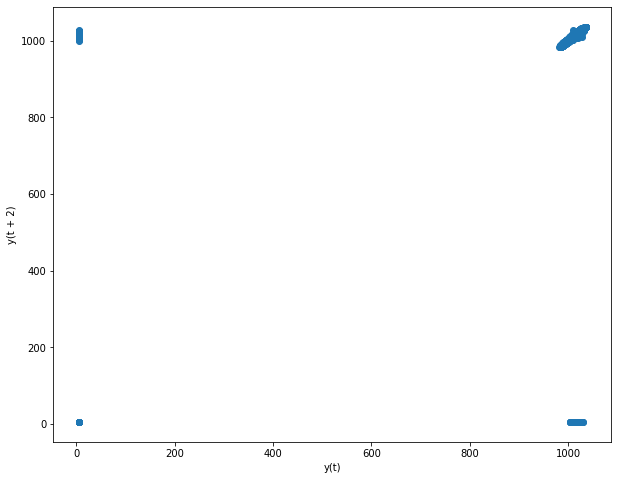

In [22]:
eda.lag_plot('PRES',2) 


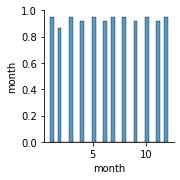

In [23]:
eda.pair_plot(df.columns[3:6]) 


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

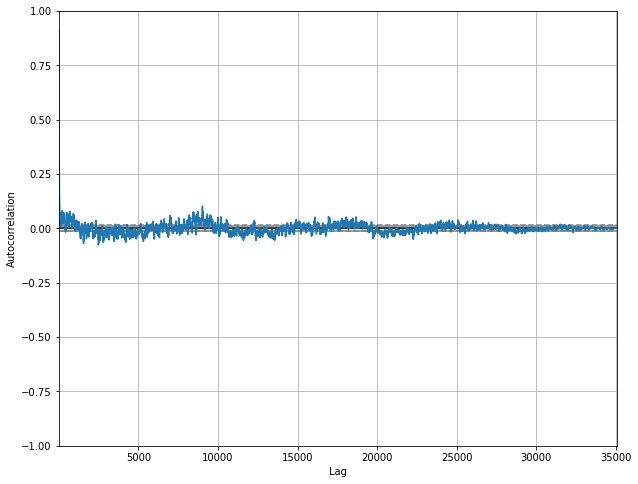

In [24]:
eda.autocorrelation_plot('PM10') 


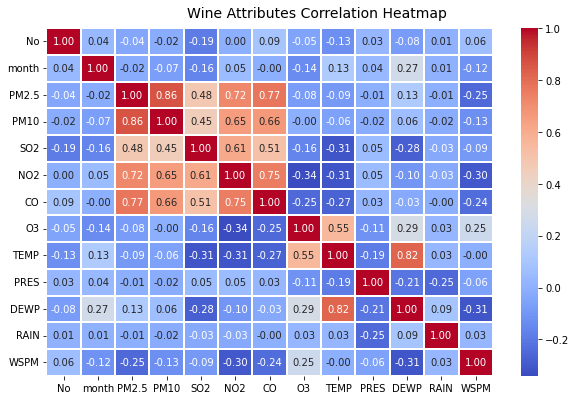

In [25]:
eda.corr_heatmap() 


In [26]:
eda.outliers('month')


Outliers


Empty DataFrame
Columns: [No, year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, wd, WSPM, station]
Index: []

In [27]:
eda.kpss_test('PM10') 


Test Statistics: 0.20030912329457867
Test Statistics: 0.20030912329457867
p-value: 0.1
Critial Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Series is Stationary


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [28]:
eda.adfuller_test('month')


Test Statistics: -3.277904265344034
p-value: 0.015895511453074673
Critial Values: {'1%': -3.430536515095767, '5%': -2.861622435067925, '10%': -2.5668138775949845}
Series is Stationary


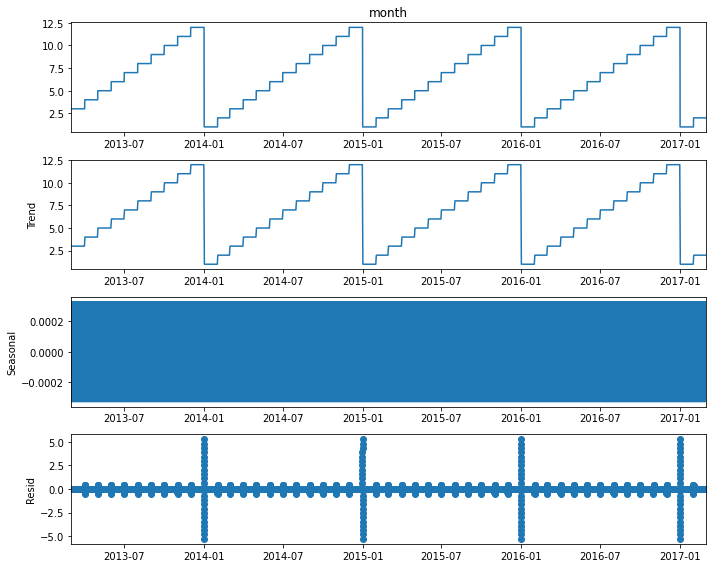

In [29]:
import statsmodels.api as sm
res = eda.plot_time_series_seasonal_decomp('month', model='additive')  # index should be date


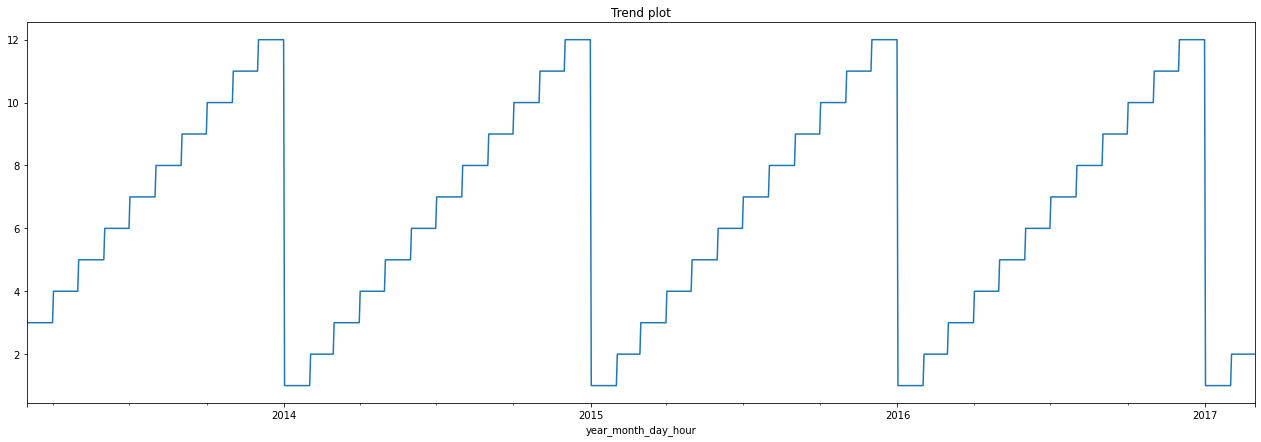

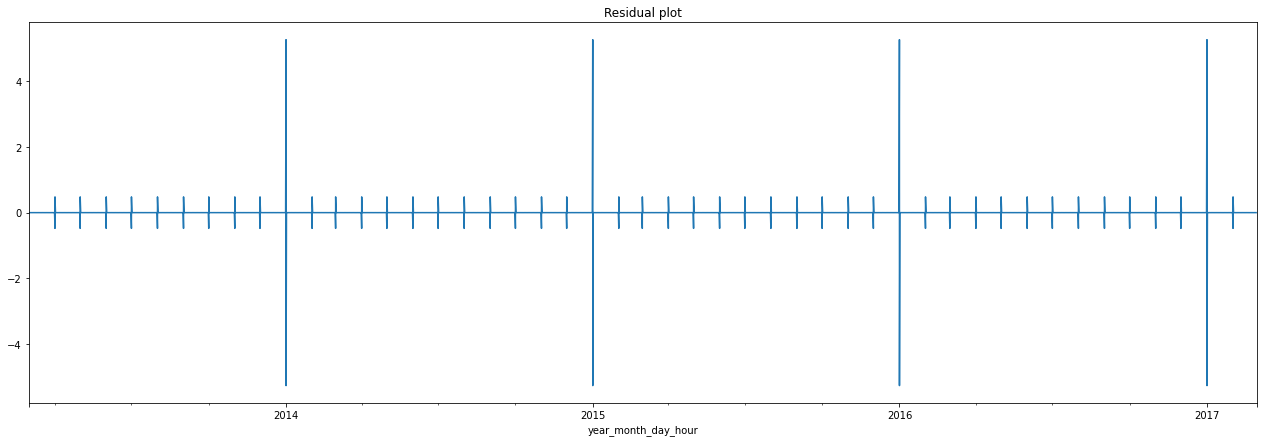

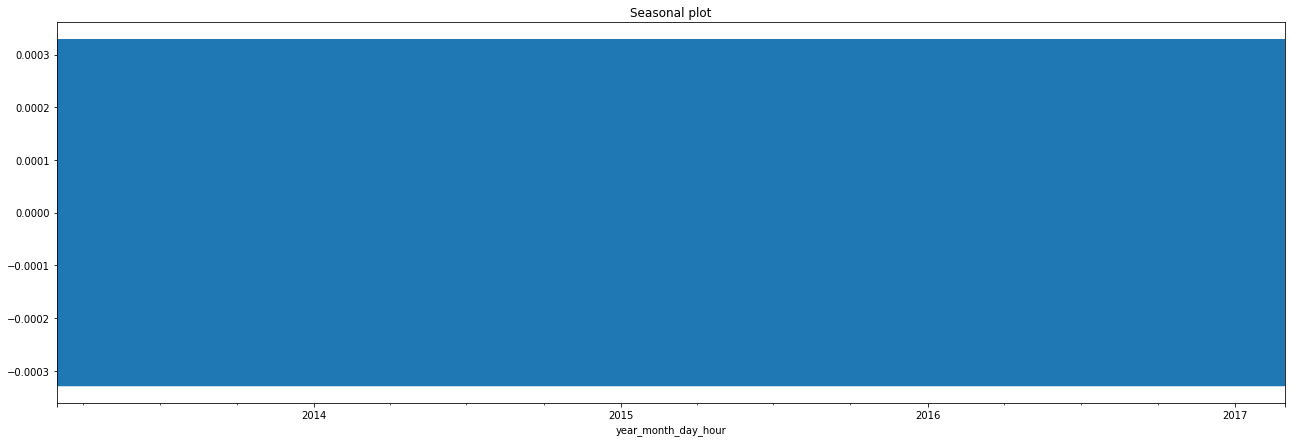

In [30]:
eda.plot_composants('month',res) 


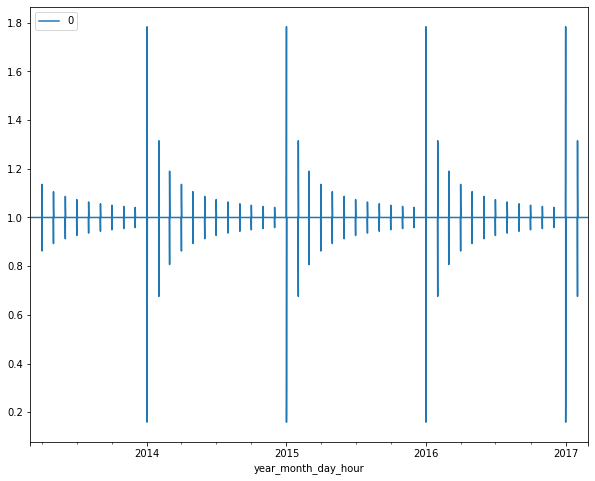

In [31]:
eda.eliminate_composant (res,'trend')


In [32]:
eda.resampling('M') # index should be date


No  month       PM2.5        PM10        SO2  \
year_month_day_hour                                                      
2013-03-31             372.5    3.0   95.705645  109.603495  24.306051   
2013-04-30            1104.5    4.0   54.300000   78.583333  13.470978   
2013-05-31            1836.5    5.0   68.010753  108.814516  16.779135   
2013-06-30            2568.5    6.0   85.073611   86.594444   7.806143   
2013-07-31            3300.5    7.0   51.772849   54.211022   4.243645   
2013-08-31            4044.5    8.0   49.791667   51.243280   4.807796   
2013-09-30            4776.5    9.0   62.859722   61.918056   5.417451   
2013-10-31            5508.5   10.0   69.879032   84.276882  11.294397   
2013-11-30            6240.5   11.0   47.306944   71.734722  19.228694   
2013-12-31            6972.5   12.0   51.780914   64.146505  30.905830   
2014-01-31            7716.5    1.0   69.197581   95.411290  34.982527   
2014-02-28            8424.5    2.0  137.708333  129.915179  33.788690   
2014-03-31            9132.5    3.0   83.290323  112.572581  22.844086   
2014-04-30            9864.5    4.0   84.536111  113.126389  11.148611   
2014-05-31           10596.5    5.0   46.850403   71.168683   9.102688   
2014-06-30           11328.5    6.0   38.151389   40.745833   4.137500   
2014-07-31           12060.5    7.0   77.159409   86.677285   4.858065   
2014-08-31           12804.5    8.0   51.306317   66.862366   4.635081   
2014-09-30           13536.5    9.0   52.984167   69.420278   5.162500   
2014-10-31           14268.5   10.0  115.126344  124.938172   6.505376   
2014-11-30           15000.5   11.0   71.230278   89.444306  15.718056   
2014-12-31           15732.5   12.0   46.330645   63.729839  19.889785   
2015-01-31           16476.5    1.0   84.241801   92.377554  27.862366   
2015-02-28           17184.5    2.0   81.007440  104.465774  23.462798   
2015-03-31           17892.5    3.0   74.232258  123.157124  14.772043   
2015-04-30           18624.5    4.0   55.527500   90.682222   6.446944   
2015-05-31           19356.5    5.0   45.693548   83.948253   6.618280   
2015-06-30           20088.5    6.0   50.383056   68.020972   6.704167   
2015-07-31           20820.5    7.0   49.486559   63.929167   4.893817   
2015-08-31           21564.5    8.0   34.747312   56.680108   5.712366   
2015-09-30           22296.5    9.0   37.652778   48.094444   3.850000   
2015-10-31           23028.5   10.0   52.455645   66.779570   7.850806   
2015-11-30           23760.5   11.0   83.861111   88.861111  12.418056   
2015-12-31           24492.5   12.0  117.888441  127.525538  15.307796   
2016-01-31           25236.5    1.0   52.239247   70.669355  15.162634   
2016-02-29           25956.5    2.0   34.785920   50.152299   9.623563   
2016-03-31           26676.5    3.0   81.037634  129.209677  12.052419   
2016-04-30           27408.5    4.0   59.016667  114.202778   6.951389   
2016-05-31           28140.5    5.0   48.896505   79.870968   4.189516   
2016-06-30           28872.5    6.0   49.059722   63.756944   3.398611   
2016-07-31           29604.5    7.0   56.311828   61.415323   2.663978   
2016-08-31           30348.5    8.0   36.770161   44.188172   2.250000   
2016-09-30           31080.5    9.0   40.611111   46.865278   3.118056   
2016-10-31           31812.5   10.0   64.430108   79.466398   2.991935   
2016-11-30           32544.5   11.0   75.495833   99.361111   9.020833   
2016-12-31           33276.5   12.0   94.622312  105.229839  14.154570   
2017-01-31           34020.5    1.0   81.266129   90.971774  13.806452   
2017-02-28           34728.5    2.0   53.233631   63.955357  12.504464   

                           NO2           CO          O3       TEMP  \
year_month_day_hour                                                  
2013-03-31           45.739373   969.235215   67.801782   5.904032   
2013-04-30           25.136527   593.790278   71.462634  12.412222   
2013-05-31           25.638392   693.188172  

In [33]:
eda.difference(1,'PM2.5')


year_month_day_hour
2013-03-01 00:00:00    NaN
2013-03-01 01:00:00    3.0
2013-03-01 02:00:00   -2.0
2013-03-01 03:00:00    1.0
2013-03-01 04:00:00   -1.0
                      ... 
2017-02-28 19:00:00    5.0
2017-02-28 20:00:00    2.0
2017-02-28 21:00:00   -4.0
2017-02-28 22:00:00    1.0
2017-02-28 23:00:00    3.0
Name: PM2.5, Length: 35064, dtype: float64

In [34]:
eda.shifting(2)


No  year  month  day hour  PM2.5  PM10  SO2  NO2  \
year_month_day_hour                                                          
2013-03-01 00:00:00      NaN   NaN    NaN  NaN  NaN    NaN   NaN  NaN  NaN   
2013-03-01 01:00:00      NaN   NaN    NaN  NaN  NaN    NaN   NaN  NaN  NaN   
2013-03-01 02:00:00      1.0  2013    3.0    1    0    4.0   4.0  3.0  5.0   
2013-03-01 03:00:00      2.0  2013    3.0    1    1    7.0   7.0  3.0  5.0   
2013-03-01 04:00:00      3.0  2013    3.0    1    2    5.0   5.0  3.0  2.0   
...                      ...   ...    ...  ...  ...    ...   ...  ...  ...   
2017-02-28 19:00:00  35058.0  2017    2.0   28   17   15.0  39.0  4.0  8.0   
2017-02-28 20:00:00  35059.0  2017    2.0   28   18    6.0  25.0  2.0  2.0   
2017-02-28 21:00:00  35060.0  2017    2.0   28   19   11.0  11.0  2.0  2.0   
2017-02-28 22:00:00  35061.0  2017    2.0   28   20   13.0  13.0  2.0  2.0   
2017-02-28 23:00:00  35062.0  2017    2.0   28   21    9.0  14.0  2.0  2.0   

                        CO     O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  \
year_month_day_hour                                                      
2013-03-01 00:00:00    NaN    NaN   NaN     NaN   NaN   NaN  NaN   NaN   
2013-03-01 01:00:00    NaN    NaN   NaN     NaN   NaN   NaN  NaN   NaN   
2013-03-01 02:00:00  200.0   82.0  -2.3  1020.8 -19.7   0.0    E   0.5   
2013-03-01 03:00:00  200.0   80.0  -2.5  1021.3 -19.0   0.0  ENE   0.7   
2013-03-01 04:00:00  200.0   79.0  -3.0  1021.3 -19.9   0.0  ENE   0.2   
...                    ...    ...   ...     ...   ...   ...  ...   ...   
2017-02-28 19:00:00  200.0   94.0  14.7  1007.4 -12.6   0.0  WNW   4.2   
2017-02-28 20:00:00  200.0   99.0  13.4  1008.1 -13.6   0.0  WNW   3.0   
2017-02-28 21:00:00  200.0   99.0  11.7  1008.9 -13.3   0.0  NNE   1.3   
2017-02-28 22:00:00  200.0  101.0  10.9  1009.0 -14.0   0.0    N   2.1   
2017-02-28 23:00:00  200.0  102.0   9.5  1009.4 -13.0   0.0    N   1.5   

                      station  
year_month_day_hour            
2013-03-01 00:00:00       NaN  
2013-03-01 01:00:00       NaN  
2013-03-01 02:00:00  Dingling  
2013-03-01 03:00:00  Dingling  
2013-03-01 04:00:00  Dingling  
...                       ...  
2017-02-28 19:00:00  Dingling  
2017-02-28 20:00:00  Dingling  
2017-02-28 21:00:00  Dingling  
2017-02-28 22:00:00  Dingling  
2017-02-28 23:00:00  Dingling  

[35064 rows x 18 columns]

In [35]:
eda.tshifting(2)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:281: FutureWarning:

tshift is deprecated and will be removed in a future version. Please use shift instead.



No  year  month day hour  PM2.5  PM10  SO2  NO2  \
year_month_day_hour                                                       
2013-03-01 02:00:00      1  2013      3   1    0    4.0   4.0  3.0  5.0   
2013-03-01 03:00:00      2  2013      3   1    1    7.0   7.0  3.0  5.0   
2013-03-01 04:00:00      3  2013      3   1    2    5.0   5.0  3.0  2.0   
2013-03-01 05:00:00      4  2013      3   1    3    6.0   6.0  3.0  5.0   
2013-03-01 06:00:00      5  2013      3   1    4    5.0   5.0  3.0  5.0   
...                    ...   ...    ...  ..  ...    ...   ...  ...  ...   
2017-02-28 21:00:00  35060  2017      2  28   19   11.0  11.0  2.0  2.0   
2017-02-28 22:00:00  35061  2017      2  28   20   13.0  13.0  2.0  2.0   
2017-02-28 23:00:00  35062  2017      2  28   21    9.0  14.0  2.0  2.0   
2017-03-01 00:00:00  35063  2017      2  28   22   10.0  12.0  2.0  2.0   
2017-03-01 01:00:00  35064  2017      2  28   23   13.0  16.0  4.0  9.0   

                        CO     O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  \
year_month_day_hour                                                      
2013-03-01 02:00:00  200.0   82.0  -2.3  1020.8 -19.7   0.0    E   0.5   
2013-03-01 03:00:00  200.0   80.0  -2.5  1021.3 -19.0   0.0  ENE   0.7   
2013-03-01 04:00:00  200.0   79.0  -3.0  1021.3 -19.9   0.0  ENE   0.2   
2013-03-01 05:00:00  200.0   79.0  -3.6  1021.8 -19.1   0.0  NNE   1.0   
2013-03-01 06:00:00  200.0   81.0  -3.5  1022.3 -19.4   0.0    N   2.1   
...                    ...    ...   ...     ...   ...   ...  ...   ...   
2017-02-28 21:00:00  200.0   99.0  11.7  1008.9 -13.3   0.0  NNE   1.3   
2017-02-28 22:00:00  200.0  101.0  10.9  1009.0 -14.0   0.0    N   2.1   
2017-02-28 23:00:00  200.0  102.0   9.5  1009.4 -13.0   0.0    N   1.5   
2017-03-01 00:00:00  200.0   97.0   7.8  1009.6 -12.6   0.0   NW   1.4   
2017-03-01 01:00:00  500.0   74.0   7.0  1009.4 -12.2   0.0    N   1.9   

                      station  
year_month_day_hour            
2013-03-01 02:00:00  Dingling  
2013-03-01 03:00:00  Dingling  
2013-03-01 04:00:00  Dingling  
2013-03-01 05:00:00  Dingling  
2013-03-01 06:00:00  Dingling  
...                       ...  
2017-02-28 21:00:00  Dingling  
2017-02-28 22:00:00  Dingling  
2017-02-28 23:00:00  Dingling  
2017-03-01 00:00:00  Dingling  
2017-03-01 01:00:00  Dingling  

[35064 rows x 18 columns]

In [36]:
eda.rolling(5)


No  month  PM2.5   PM10   SO2   NO2      CO     O3  \
year_month_day_hour                                                             
2013-03-01 00:00:00       NaN    NaN    NaN    NaN   NaN   NaN     NaN    NaN   
2013-03-01 01:00:00       NaN    NaN    NaN    NaN   NaN   NaN     NaN    NaN   
2013-03-01 02:00:00       NaN    NaN    NaN    NaN   NaN   NaN     NaN    NaN   
2013-03-01 03:00:00       NaN    NaN    NaN    NaN   NaN   NaN     NaN    NaN   
2013-03-01 04:00:00      15.0   15.0   27.0   27.0  15.0  22.0  1000.0  401.0   
...                       ...    ...    ...    ...   ...   ...     ...    ...   
2017-02-28 19:00:00  175290.0   10.0   62.0  132.0  19.0  23.0  1005.0  473.0   
2017-02-28 20:00:00  175295.0   10.0   59.0  118.0  15.0  20.0   805.0  486.0   
2017-02-28 21:00:00  175300.0   10.0   54.0  102.0  12.0  16.0  1000.0  495.0   
2017-02-28 22:00:00  175305.0   10.0   49.0   75.0  10.0  10.0  1000.0  498.0   
2017-02-28 23:00:00  175310.0   10.0   56.0   66.0  12.0  17.0  1300.0  473.0   

                     TEMP    PRES  DEWP  RAIN  WSPM  
year_month_day_hour                                  
2013-03-01 00:00:00   NaN     NaN   NaN   NaN   NaN  
2013-03-01 01:00:00   NaN     NaN   NaN   NaN   NaN  
2013-03-01 02:00:00   NaN     NaN   NaN   NaN   NaN  
2013-03-01 03:00:00   NaN     NaN   NaN   NaN   NaN  
2013-03-01 04:00:00 -14.9  5107.5 -97.1   0.0   4.5  
...                   ...     ...   ...   ...   ...  
2017-02-28 19:00:00  70.8  5039.2 -65.2   0.0  16.1  
2017-02-28 20:00:00  66.1  5040.6 -66.4   0.0  15.0  
2017-02-28 21:00:00  60.2  5042.8 -66.5   0.0  12.1  
2017-02-28 22:00:00  53.3  5045.0 -66.5   0.0   9.3  
2017-02-28 23:00:00  46.9  5046.3 -65.1   0.0   8.2  

[35064 rows x 13 columns]

In [37]:
eda.group ("weekly")


No     month      PM2.5       PM10        SO2  \
year_month_day_hour                                                       
0                    17556.5  6.526316  59.829844  79.723485  11.587237   
1                    17580.5  6.559809  61.601874  78.494338  11.681112   
2                    17520.5  6.557692  61.209575  76.281791  11.006235   
3                    17544.5  6.528846  63.749038  79.990485  10.929354   
4                    17484.5  6.483254  67.504825  84.732855  11.846290   
5                    17508.5  6.511962  71.877592  90.292823  12.372034   
6                    17532.5  6.492823  66.648285  86.310965  11.835499   

                           NO2          CO         O3       TEMP         PRES  \
year_month_day_hour                                                             
0                    25.060251  774.894737  67.323521  13.714910  1006.656223   
1                    27.022794  845.075359  64.883349  13.458859  1006.947947   
2                    26.064975  809.504808  65.994524  13.585338  1005.852340   
3                    24.979003  823.199519  66.847979  13.734026  1006.125855   
4                    27.491837  881.125000  65.100826  13.668990  1006.008416   
5                    29.659669  942.404506  66.027616  13.806544  1006.237184   
6                    27.243680  896.258174  68.260100  13.742080  1006.481413   

                         DEWP      RAIN      WSPM  
year_month_day_hour                                
0                    1.220674  0.055482  1.908413  
1                    1.399222  0.062520  1.841746  
2                    1.408313  0.091186  1.830990  
3                    1.349219  0.053826  1.918970  
4                    1.689254  0.083852  1.822069  
5                    1.955662  0.073545  1.775020  
6                    1.551834  0.052492  1.906818

In [38]:
eda.cummulative_sum ('PM10') 


PM10
year_month_day_hour           
2013-03-01 00:00:00        4.0
2013-03-01 01:00:00       11.0
2013-03-01 02:00:00       16.0
2013-03-01 03:00:00       22.0
2013-03-01 04:00:00       27.0
...                        ...
2017-02-28 19:00:00  2884541.4
2017-02-28 20:00:00  2884554.4
2017-02-28 21:00:00  2884568.4
2017-02-28 22:00:00  2884580.4
2017-02-28 23:00:00  2884596.4

[35064 rows x 1 columns]

In [39]:
eda.pourcentage_change ('PM2.5',2)  

year_month_day_hour
2013-03-01 00:00:00         NaN
2013-03-01 01:00:00         NaN
2013-03-01 02:00:00    0.250000
2013-03-01 03:00:00   -0.142857
2013-03-01 04:00:00    0.000000
                         ...   
2017-02-28 19:00:00   -0.266667
2017-02-28 20:00:00    1.166667
2017-02-28 21:00:00   -0.181818
2017-02-28 22:00:00   -0.230769
2017-02-28 23:00:00    0.444444
Name: PM2.5, Length: 35064, dtype: float64

3. Modeling 

3.1 Auto Arima

The conventional ARIMA model assumes that the historical data are useful to predict the value at the next time step. In this case, this is somewhat true, as the ACF plot before showed past value is somewhat correlated with today's value.

ARIMA basically integrates two naive forecasting techniques together:

Autoregression - Uses one or more past values to forecast the future. The number of values used is known as the 'order' (e.g. order 2 means yesterday and day before's value is used)

Integrating - the part that reduces seasonality. How many degrees of differencing is done to reduce seasonality is the 'order'.

Moving Average - Uses the Moving Average of the historical data to adjust the forecasted values. This has a 'smoothing' effect on the past data, as it uses the moving average rather than the actual values of the past. The number of days in the moving average window is the 'order'

Here a demonstration on how to Use Arima on the dataset below that we will consider 

In [40]:
!pip install pmdarima
# import pmdarima as pm

# The data to consider : 
df = df[['year_month_day_hour','PM10']]
df['PM10'] = df['PM10'].astype('float64')
df['PM10'].fillna(method = 'ffill',inplace=True)
df = df.set_index('year_month_day_hour')

__init__ : Constructor of the class 

arima_model(target) : define the arima model that we will use

data_split(condition_1,condition_2) : it will serve to split the data into train and test based on two conditions 

arima_fit : fitting the arima model 

predict : predicting the future with the fitted model

df_predict : return the predicted values  in one dataframe

prediction_plot : plotting the predictions







In [41]:
class Auto_Arima () : 

  def __init__ (self,df) : 

    """ 
    Constructor of the class

    """
    self.df = df
  def arima_model (self,target) :

    """
    Define the arima model that we will use

    """
    self.model = pm.auto_arima(self.df[target], 
                            m=1, seasonal=True,
                          start_p=0, start_q=0, max_order=1, test='adf',error_action='ignore',  
                              suppress_warnings=True,
                          stepwise=True, trace=True)
    
  def data_split (self,condition_1,condition_2) : 

    """ 
    This function will serve to split the data into train and test based on two conditions
    
    """ 
    self.train=self.df[(self.df.index >= condition_1) & (self.df.index <= condition_2)]
    self.test=self.df[(self.df.index > condition_2)]    

  def arima_fit (self,target) : 

    """
    Fitting the arima model
    
    """
    self.model.fit(self.train[target])

  def predict (self) : 

    """ 
    predicting the future with the fitted model

    """
    self.forecast=self.model.predict(n_periods=self.test.shape[0], return_conf_int=True)

  def df_predict(self) : 

    """

    return the predicted values in one dataframe

    """
    self.forecast_df = pd.DataFrame(self.forecast[0],index = self.test.index,columns=['Predictions'])

  def prediction_plot (self,target) : 

    """
     plotting the predictions
     
     """
    pd.concat([self.df[target],self.forecast_df],axis=1).plot()


In [42]:
df = pd.read_csv('/tmp/aq/PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv', parse_dates = [['year', 'month', 'day', 'hour']],date_parser=convert_to_date, keep_date_col=True)
auto_arima = Auto_Arima(df)
# auto_arima.arima_model('PM10')
# auto_arima.data_split('2013-03-01 00:00:00','2016-03-01 00:00:00')
# auto_arima.arima_fit('PM10')
# auto_arima.predict (8759) # test.shape[0] shld be equal to  n_periods 
# auto_arima.df_predict()
# auto_arima.prediction_plot('PM10')

3.2 Prophet

Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

Here we perform a demonstration on eda.df as a dataframe : 

__init__(self,df) : Constructor of the class 

 prepare_data (self,timestamp,target) : function to prepare the data as 'ds' and  'y' columns in order to pass them to prophet model

 data_split (self,start_index,end_index) : function to split the data into train and test based on start and end indexes 

 prophet_model (self,yearly_seasonality) : function to define the profet object model 

 fit (self) : function to fit the model 

 prepare_future (self,periods) : function to prepare the periods of the future 

 predict(self) : function to predict the future 

 plot_prediction_label (self) : function to plot the label and the prediction 

 plot_prediction(self) : A function to plot the predictions 

plot_components(self) : A function to plot the different compononts .. trend .. weekly seasonality .. yearly seasonality 

add_change_points (self) : A function serving to add change points to the plots 

plot_change_points (self) : A function serve to plot change points on 80/100 of the train data 

plot(self) : Plotting the forecast with plotly framework

cross_val (self,initial,horizon) : A function to perform cross validation and get results 

performance_metric (self) : A function to get the performance of the prophet model 



In [43]:
class Prophet_Modeling () : 
  def __init__(self,df) : 
    self.df = df 
  def prepare_data (self,timestamp,target) : 
    self.df=self.df[[timestamp,target]].rename({timestamp:'ds',target:'y'}, axis='columns')

  def data_split (self,start_index,end_index) : 
    self.train=self.df[(self.df['ds'] >= start_index) & (self.df['ds'] <=end_index)]
    self.test=self.df[(self.df['ds'] > end_index)]
  def prophet_model (self,yearly_seasonality) :
    self.model = Prophet(interval_width=0.8,yearly_seasonality=yearly_seasonality)
  def fit (self) : 
    self.model.fit(self.train)
  def prepare_future (self,periods) : 
    self.future = self.model.make_future_dataframe(periods=periods) # test.shape[0] = 104
  def predict(self) : 
    self.forecast = self.model.predict(self.future)
  def plot_prediction_label (self) : 
    pd.concat([self.df.set_index('ds')['y'],self.forecast.set_index('ds')['yhat']],axis=1).plot()
  def plot_prediction (self) : 
    fig1 = self.model.plot(self.forecast)
  def plot_components(self) : 
    fig2 = self.model.plot_components(self.forecast)
  def add_change_points (self) : 
    fig = self.model.plot(self.forecast)
    a = add_changepoints_to_plot(fig.gca(), self.model, self.forecast)
  def plot_change_points (self) : 
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111)
    ax.bar(range(len(self.model.params['delta'].mean(0))), self.model.params['delta'].mean(0))
    ax.grid(True, which='major', c='red', ls='-', lw=1, alpha=0.2)
    ax.set_ylabel('Rate change')
    ax.set_xlabel('changepoint')
    fig.tight_layout()
  def plot(self) : 
    from fbprophet.plot import plot_plotly
    import plotly.offline as py
    fig = plot_plotly(self.model, self.forecast) 
    py.iplot(fig)
  def cross_val (self,initial,horizon) : 
    self.cv_results = cross_validation( model = self.model, initial =initial, horizon = horizon)
  def performance_metric (self) : 
    self.df_p = performance_metrics(self.cv_results)


In [44]:
# The data to consider : 
df = pd.read_csv('/tmp/aq/PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv', parse_dates = [['year', 'month', 'day', 'hour']],date_parser=convert_to_date, keep_date_col=True)
df = df[['year_month_day_hour','PM10']]
df['PM10'] = df['PM10'].astype('float64')
df['PM10'].fillna(method = 'ffill',inplace=True)

In [45]:
prophet = Prophet_Modeling(df)


In [46]:
prophet.prepare_data('year_month_day_hour','PM10')


In [47]:
prophet.data_split('2013-03-01 00:00:00','2016-05-30 00:00:00	')


In [48]:
prophet.prophet_model(yearly_seasonality=True)


In [49]:
prophet.fit()


Initial log joint probability = -150.208
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       55053.3     0.0231409         740.8           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       55072.5     0.0110465       154.973           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       55084.6    0.00248105       866.574       2.004      0.2004      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       55092.4    0.00283291       185.733           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       55095.2   0.000381732       173.623      0.7085      0.7085      584   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [50]:
prophet.prepare_future(prophet.test.shape[0]) #104


In [51]:
prophet.predict()


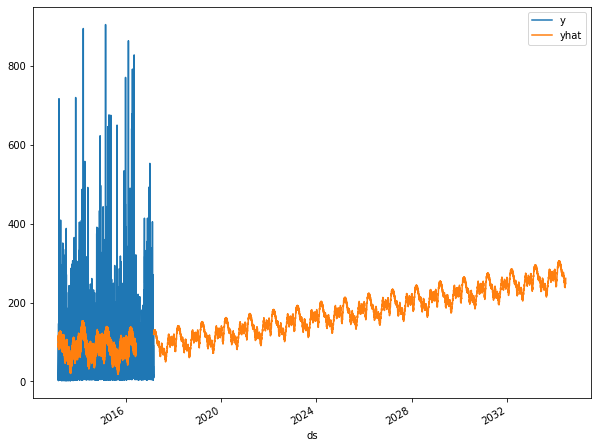

In [52]:
prophet.plot_prediction_label()


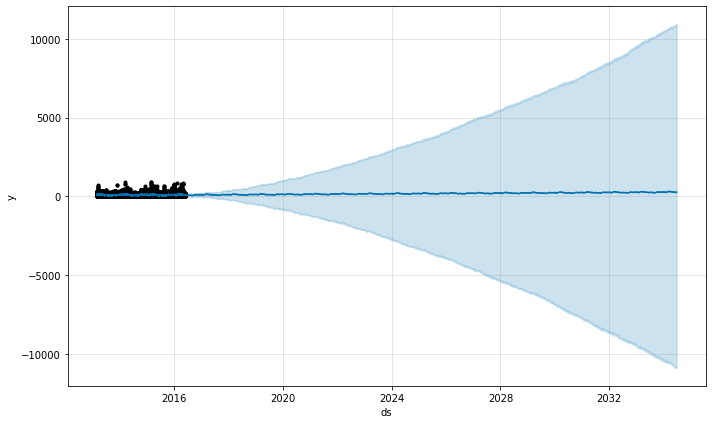

In [53]:
prophet.plot_prediction()


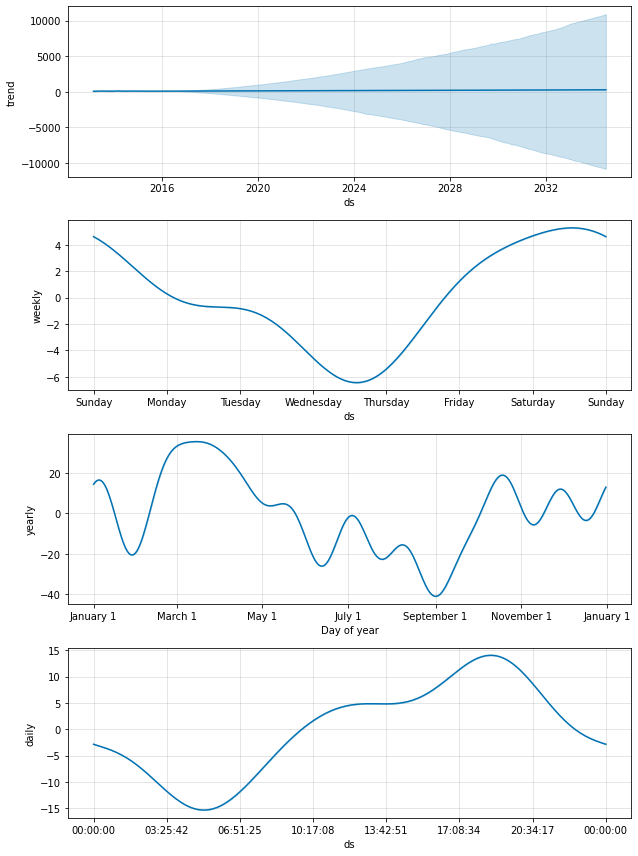

In [54]:
prophet.plot_components()


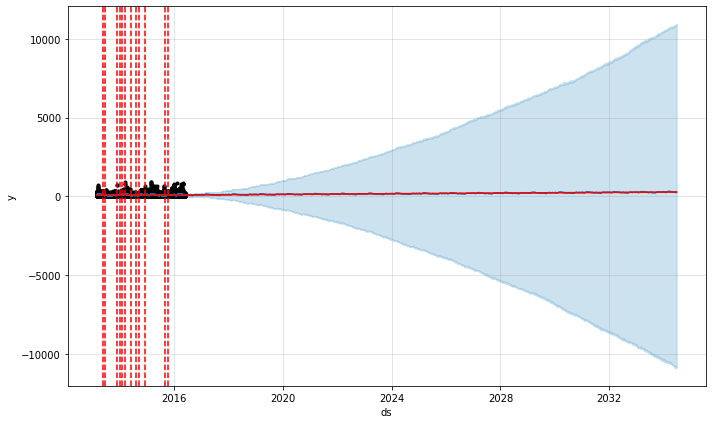

In [55]:
prophet.add_change_points()


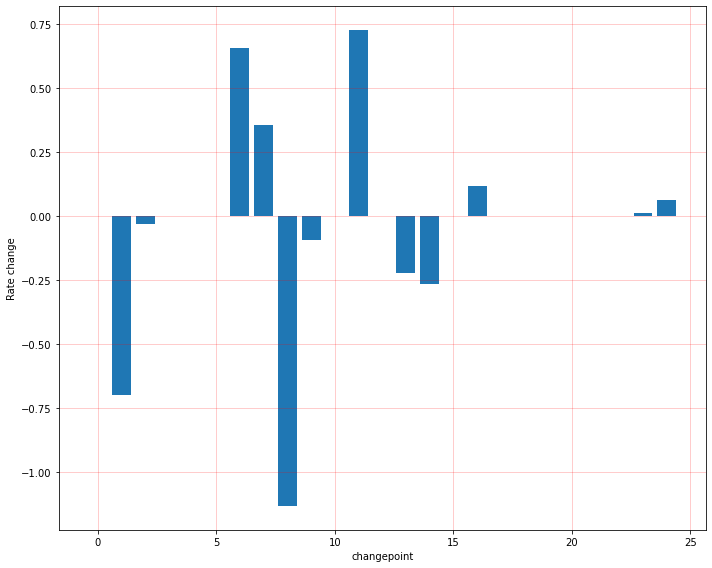

In [56]:
prophet.plot_change_points()


In [57]:
prophet.plot()


In [58]:
prophet.cross_val('731 days','365 days')
prophet.performance_metric()

  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -111.128
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       38568.1     0.0071934       1642.95           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       38579.3     0.0110686       573.883           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       38582.6   3.39975e-05       113.648   1.314e-07       0.001      370  LS failed, Hessian reset 
     299       38582.8    0.00199536       163.831           1           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347       38583.9   3.61392e-05       144.062   1.527e-07       0.001      524  LS failed, Hessian reset 
     399       38584.3   1.37476e-05       42.1073           1           1      593   
    Iter      log pro

3.3 LSTM

Time series prediction problems are a difficult type of predictive modeling problem.

Unlike regression predictive modeling, time series also adds the complexity of a sequence dependence among the input variables.

A powerful type of neural network designed to handle sequence dependence is called recurrent neural networks. The Long Short-Term Memory network or LSTM network is a type of recurrent neural network used in deep learning because very large architectures can be successfully trained.

LSTM can be used for : 
-  univariate time series forecasting. 
- multivariate time series forecasting 
- multi-step time series forecasting

In our case I will explain the use of LSTM in Univariate Time Series Forecasting . Please let me know in the comments if you want codes / Explanations for multivariate Time Series Forecasting 

In [59]:
class CFG :
  win_length=720 
  num_features = 4 
  sampling_rate = 1 
  batch_size=32
  scaler = MinMaxScaler()
  input_shape= (win_length, num_features)
  lstm_neurons = 32
  alpha = 0.5 
  dropout = 0.3

__init__(self,df) : Constructor of the class

scaling(self) : in order to scale the data 

data_prepare(self) : function to prepare features + target

data_split (self) : function to split data into train + test 

sequences_prepare (self) : Function to prepare sequences train and test data . I recommend to check the documentation of TimeSeriesGenerator in order to get understand more the functionning of this function

inverse_scaling (self,predictions) : WARNING !!! Don't forget to inverse the scale of the features 

final_df(self,predictions,rev_trans) : function to prepare the final_df 


In [60]:
class LSTM_DATA_PREPARE () :
  def __init__(self,df) : 
    self.df = df
  def scaling (self) : 
    self.df_scaled = CFG.scaler.fit_transform(self.df)
  def data_prepare (self) : 
    self.features=self.df_scaled
    self.target=self.df_scaled[:,0]
  def data_split (self) : 
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.features, 
          self.target, test_size=0.20, random_state=123, shuffle = False)
  def sequences_prepare (self) : 
      self.train_generator = TimeseriesGenerator(self.x_train, self.y_train, length=CFG.win_length, sampling_rate=CFG.sampling_rate, batch_size=CFG.batch_size)
      self.test_generator = TimeseriesGenerator(self.x_test, self.y_test, length=CFG.win_length, sampling_rate=CFG.sampling_rate, batch_size=CFG.batch_size)
  def inverse_scaling (self,predictions) : 
    df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(self.x_test[:,1:][CFG.win_length:])],axis=1)
    rev_trans=CFG.scaler.inverse_transform(df_pred) # 3léh inversion tsir kén 3al df_pred 3al predictions khw mayakfich 
    return rev_trans
  def final_df (self,predictions,rev_trans) : 
    df_final=self.df[predictions.shape[0]*-1:]
    df_final['Pred']=rev_trans[:,0]
    return df_final
    

In [61]:
# The data to consider 
df = pd.read_csv('/tmp/aq/PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv', parse_dates = [['year', 'month', 'day', 'hour']],date_parser=convert_to_date, keep_date_col=True)
df1 = df[['PM2.5','O3','TEMP','PRES']].fillna(5) # choisir data que vous voulez ......


In [62]:
data = LSTM_DATA_PREPARE(df1)
data.scaling()
data.data_prepare()
data.data_split()
# data.sequences_prepare()
# data.train_generator + data.test_generator : da5lét eda.df[colonnes choisis] 5arjét hal zouz fihom les séquences 

Here just as an exmple of 3 layers of LSTM .. feel free to choose the model you want .. and the hyperparams you want .. This model is coded with the subclassing Tensorflow method . All the codes should be in a class ( at least a function ) to get a clean code 

In [63]:

class LSTM_MODEL (tf.keras.Model) : 
  def __init__(self):
    super(LSTM_MODEL, self).__init__()
    self.lstm1 = layers.LSTM(CFG.lstm_neurons*4, input_shape= CFG.input_shape, return_sequences=True)
    self.lstm2 = layers.LSTM(CFG.lstm_neurons*2, return_sequences=True)
    self.lstm3 = layers.LSTM(CFG.lstm_neurons, return_sequences=False)
    self.activation = layers.LeakyReLU(alpha=CFG.alpha)
    self.dropout = layers.Dropout(CFG.dropout)
    self.dense = layers.Dense(1) 
  def call (self,inputs) : 
    x = self.dropout(self.activation(self.lstm1(inputs)))
    x = self.dropout(self.activation(self.lstm2(x)))
    x = self.dense((self.activation(self.lstm3(x))))
    return x

In [64]:
# model = LSTM_MODEL()
# model.compile(loss=tf.losses.MeanSquaredError(),
#               optimizer=tf.optimizers.Adam(),
#               metrics=[tf.metrics.MeanAbsoluteError()])
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=2,
#                                                     mode='min')
# history = model.fit(data.train_generator, epochs=1,validation_data=data.test_generator,shuffle=False
#                               ,callbacks=[early_stopping],verbose=1) 
# predictions=model.predict(data.test_generator)
# # data.y_test , predictions 
# # ATTENTIONNNNNNNNNNNN : y_test w predictions hna mayét9arnouch les prédictions sarou 3la data scaled .. donc lezmk ta3ml opération
# # inverse pour pouvoir comparer .. predictions w l y_test

In [65]:
# rev_trans = data.inverse_scaling (predictions)
# final_df = data.final_df(predictions,rev_trans)

In [66]:
# final_df

4. DeepAR

The Amazon SageMaker DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNN). Classical forecasting methods, such as autoregressive integrated moving average (ARIMA) or exponential smoothing (ETS), fit a single model to each individual time series. They then use that model to extrapolate the time series into the future.

In many applications, however, you have many similar time series across a set of cross-sectional units. For example, you might have time series groupings for demand for different products, server loads, and requests for webpages. For this type of application, you can benefit from training a single model jointly over all of the time series. DeepAR takes this approach. When your dataset contains hundreds of related time series, DeepAR outperforms the standard ARIMA and ETS methods. You can also use the trained model to generate forecasts for new time series that are similar to the ones it has been trained on.

The training input for the DeepAR algorithm is one or, preferably, more target time series that have been generated by the same process or similar processes. Based on this input dataset, the algorithm trains a model that learns an approximation of this process/processes and uses it to predict how the target time series evolves. Each target time series can be optionally associated with a vector of static (time-independent) categorical features provided by the cat field and a vector of dynamic (time-dependent) time series provided by the dynamic_feat field. SageMaker trains the DeepAR model by randomly sampling training examples from each target time series in the training dataset. Each training example consists of a pair of adjacent context and prediction windows with fixed predefined lengths. To control how far in the past the network can see, use the context_length hyperparameter. To control how far in the future predictions can be made, use the prediction_length hyperparameter. For more information, see How the DeepAR Algorithm Works.

__init__ (self,df) : the constructor of the class 

prepare_train (self,start_index,target_index,target,freq) : To prepare the train data from a start_index and target index 

prepare_test (self,start_index,target_index,target,freq) : prepare the test from a start index to a target_index

estimator (self,freq,context_length,prediction_length,num_layers,num_cells,cell_type,epochs) : In order to fix the architecture of the estimator .. num_layers , cell_type etc ... 

train(self) : to do the fit 

evaluate (self,num_samples=100) : to do evaluation task 

plot_prob_forecasts(self, index) : plot the forecasts 



In [67]:
class DeepAR() : 
  def __init__(self,df) : 

    """ 
    init (self,df) : the constructor of the class

    """
    self.df = df
  def prepare_train (self,start_index,target_index,target,freq) : 
    
     """ 
     To prepare the train data from a start_index and target index
     """
     self.training_data = ListDataset([{"start": start_index, "target": self.df[target][:target_index]}],freq = freq)

  def prepare_test (self,start_index,target_index,target,freq) : 

    self.test_data = ListDataset([{"start": start_index, "target": self.df[target][:target_index]}],freq = freq)

  def estimator (self,freq,context_length,prediction_length,num_layers,num_cells,cell_type,epochs) : 

    """"
    In order to fix the architecture of the estimator .. num_layers , cell_type etc ...
    
    """

    self.estimator = DeepAREstimator(freq=freq, 
                            context_length=context_length,  
                            prediction_length=prediction_length,
                            num_layers=num_layers,
                                               
                            num_cells=num_cells,
                            cell_type=cell_type,
                            trainer=Trainer(epochs=epochs)) 
                          
    self.prediction_length = prediction_length

  def train(self) : 

    """
    to do the fit
    
    """
    self.predictor = self.estimator.train(training_data=self.training_data)

  def evaluate (self,num_samples=100) : 

    """ 
    to do evaluation task

    """
    forecast_it, ts_it = make_evaluation_predictions(
    dataset=self.test_data,  
    predictor=self.predictor,   
    num_samples=num_samples, 
    )
    self.forecasts = list(forecast_it)
    self.tss = list(ts_it)
  def plot_prob_forecasts(self, index):

    """
    plot the forecasts
    
    """
    plot_length = self.prediction_length
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    self.tss[index][-plot_length:].plot(ax=ax) 
    self.forecasts[index].plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [68]:
# Data to consider 
df = pd.read_csv('/tmp/aq/PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv', parse_dates = [['year', 'month', 'day', 'hour']],date_parser=convert_to_date, keep_date_col=True)
df = df.set_index('year_month_day_hour') # to use it to split the data 


/opt/conda/lib/python3.7/site-packages/gluonts/dataset/common.py:323: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/opt/conda/lib/python3.7/site-packages/gluonts/dataset/common.py:326: FutureWarning:

Timestamp.freq is deprecated and will be removed in a future version

/opt/conda/lib/python3.7/site-packages/gluonts/dataset/common.py:328: FutureWarning:

Timestamp.freq is deprecated and will be removed in a future version

/opt/conda/lib/python3.7/site-packages/gluonts/dataset/common.py:328: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/opt/conda/lib/python3.7/site-packages/gluonts/transform/split.py:36: FutureWarning:

Timestamp.freq is deprecated and will be removed in a future version

/opt/conda/lib/python3.7/site-packages/gluonts/transform/feature.py:352: FutureWarning:

Timestamp.freq is deprecated and will be removed in a future version

  0%|          | 0/50 [

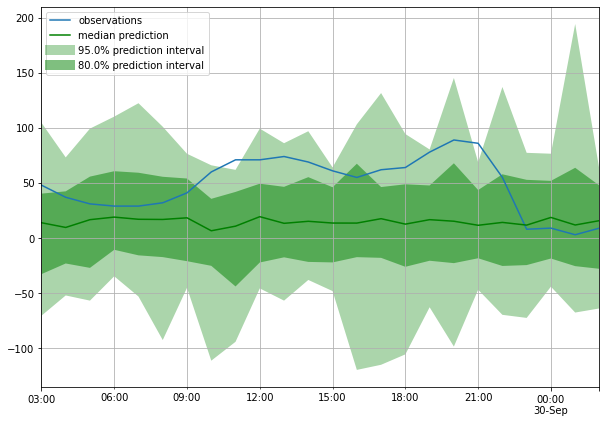

In [69]:
deepar = DeepAR(df)
deepar.prepare_train('2013-03-01 00:00:00','2016-10-01 01:00:00','PM2.5','H')
deepar.prepare_test('2016-10-01 01:00:00','2017-02-28 01:00:00','PM2.5','H')
deepar.estimator('H',120,24,2,2,"lstm",1)
deepar.train()
deepar.evaluate (num_samples=100)
deepar.plot_prob_forecasts(0)

5. Isolation forest (Anomaly Detection) 

Any data point/observation that deviates significantly from the other observations is called an Anomaly/Outlier. Anomaly detection is important and finds its application in various domains like detection of fraudulent bank transactions, network intrusion detection, sudden rise/drop in sales, change in customer behavior, etc.

Many techniques were developed to detect anomalies in the data. In this article, we will look at the implementation of Isolation Forests – an unsupervised anomaly detection technique.

Isolation Forests(IF), similar to Random Forests, are build based on decision trees. And since there are no pre-defined labels here, it is an unsupervised model.

IsolationForests were built based on the fact that anomalies are the data points that are “few and different”.

In an Isolation Forest, randomly sub-sampled data is processed in a tree structure based on randomly selected features. The samples that travel deeper into the tree are less likely to be anomalies as they required more cuts to isolate them. Similarly, the samples which end up in shorter branches indicate anomalies as it was easier for the tree to separate them from other observations.

Let’s take a deeper look at how we are going to code it . 

__init__ (self,df) : constructor of the class 

model(self,contamination,n_estimators) : build the Isolation forest model 

fit(self,column) : to fit the column you want to extract its outliers 

outliers_column (self,column) : add a column with name outliers with role to say if the observation is an outlier or not 

outliers_extract (self) : to extract the outliers in a dataframe

 outliers_plot (self,timestamp,column,title) : Plot of the outlier red if outlier , blue if not

In [70]:
# Voir sans contamination : https://github.com/srivatsan88/End-to-End-Time-Series
# from sklearn.ensemble import IsolationForest

# class Isolation_Forest_Contam () : 
#   def __init__ (self,df) : 
#     """ 
#     constructor of the class
#     """
#     self.df = df

#   def model(self,contamination,n_estimators) : 
#     """
#      build the Isolation forest model
#      """
#     self.model =  IsolationForest(contamination=contamination, n_estimators=n_estimators)

#   def fit(self,column) : 
#     """
#     to fit the column you want to extract its outliers
#     """
#     self.model.fit(self.df[[column]])

#   def outliers_column (self,column) : 
#     """
#     add a column with name outliers with role to say if the observation is an outlier or not
#     """
#     self.df['outliers']=pd.Series(self.model.predict(self.df[[column]])).apply(lambda x: 'yes' if (x == -1) else 'no' )

#   def outliers_extract (self) :
#     """
#     to extract the outliers in a dataframe
#     """
#     return self.df.query('outliers=="yes"') 
    
#   def outliers_plot (self,timestamp,column,title) :
#     """
#     Plot of the outlier red if outlier , blue if not
#     """

#     fig = px.scatter(self.df, x=timestamp, y=column, color='outliers', title=title)
#     fig.update_xaxes(
#         rangeslider_visible=True,
#     )
#     fig.show()
  

In [71]:
df = pd.read_csv('/tmp/aq/PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv', parse_dates = [['year', 'month', 'day', 'hour']],date_parser=convert_to_date, keep_date_col=True)
df = df[['year_month_day_hour' , 'PM10']].fillna(5)

In [72]:
# isolation = Isolation_Forest_Contam(df[['year_month_day_hour' , 'PM10']].fillna(5))
# isolation.model(0.005,200)
# isolation.fit('PM10')
# isolation.outliers_column('PM10')
# df_outlierd = isolation.outliers_extract()
# isolation.outliers_plot('year_month_day_hour','PM10','test')

6. Auto Encoder for Anomaly Detection 

6.1 Auto Encoders in General 

Autoencoder is a type of neural network that can be used to learn a compressed representation of raw data.

An autoencoder is composed of an encoder and a decoder sub-models. The encoder compresses the input and the decoder attempts to recreate the input from the compressed version provided by the encoder. After training, the encoder model is saved and the decoder is discarded.

The encoder can then be used as a data preparation technique to perform feature extraction on raw data that can be used to train a different machine learning model. I highly recommend that you get through more sophisticated tutorials in order to understand the details of Auto Encoders

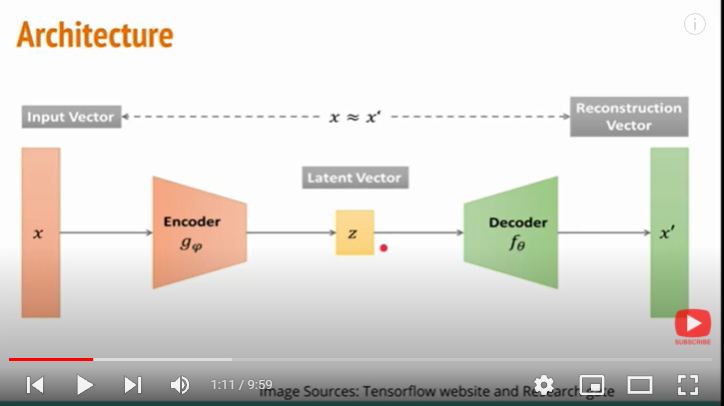

6.2 Auto Encoder for Anomaly detection

In [73]:
# Data to consider
!wget http://www.timeseriesclassification.com/Downloads/ECG5000.zip
!unzip ECG5000.zip
!ls -alrt
!cat ECG5000_TRAIN.txt ECG5000_TEST.txt > ecg_final.txt
!head ecg_final.txt
df=pd.read_csv('ecg_final.txt', sep='  ', header=None)
df = df.add_prefix('c')

--2021-10-12 14:55:23--  http://www.timeseriesclassification.com/Downloads/ECG5000.zip
Resolving www.timeseriesclassification.com (www.timeseriesclassification.com)... 109.123.71.232
Connecting to www.timeseriesclassification.com (www.timeseriesclassification.com)|109.123.71.232|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10614407 (10M) [application/zip]
Saving to: ‘ECG5000.zip’

ECG5000.zip         100%[===================>]  10.12M  7.55MB/s    in 1.3s    

2021-10-12 14:55:25 (7.55 MB/s) - ‘ECG5000.zip’ saved [10614407/10614407]

Archive:  ECG5000.zip
  inflating: ECG5000.txt             
  inflating: ECG5000_TEST.arff       
  inflating: ECG5000_TEST.txt        
  inflating: ECG5000_TRAIN.arff      
  inflating: ECG5000_TRAIN.txt       
  inflating: ECG5000_TEST.ts         
  inflating: ECG5000_TRAIN.ts        
total 43868
-rw-r--r-- 1 root root 10614407 Aug  9  2019 ECG5000.zip
-rw-r--r-- 1 root root  7086857 Aug  9  2019 ECG5000_TEST.arff
-rw-r--r-- 1

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [74]:
df.columns

Index(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9',
       ...
       'c131', 'c132', 'c133', 'c134', 'c135', 'c136', 'c137', 'c138', 'c139',
       'c140'],
      dtype='object', length=141)

__init__ (self,df) : constructor of the class

data_split (self) : prepare the train data and test .. ( As a quick remark here we don't need the labels it is a Unsupervised method ) 

data_scaling_fit (self,scaler) : a function to scale the data

data_scaling_transform (self) : part two of the scale 

data_anomaly_normal_split (self) : a function to split the data on 4 parts train_normal , train_anomaly , test_normal , test_anomaly 

In [75]:
class Data_prepare () : 
  def __init__ (self,df) : 
    self.df  = df
  def data_split (self) : 
    self.train_data, self.test_data, _1 , _2 = train_test_split(self.df.values, self.df.values[:,0:1], test_size=0.2, random_state=111)
  def data_scaling_fit (self,scaler) : 
    self.data_scaled = scaler.fit(self.train_data)
  def data_scaling_transform (self) : 
    self.train_data_scaled = self.data_scaled.transform(self.train_data)
    self.test_data_scaled = self.data_scaled.transform(self.test_data)
  def data_anomaly_normal_split (self) : # Train data wala fiha normal w anomaly w test data kifkif fiha normal w fiha anomaly .....
    self.normal_train_data= pd.DataFrame(self.train_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
    self.anomaly_train_data = pd.DataFrame(self.train_data_scaled).add_prefix('c').query('c0 > 0').values[:,1:]
    self.normal_test_data= pd.DataFrame(self.test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
    self.anomaly_test_data = pd.DataFrame(self.test_data_scaled).add_prefix('c').query('c0 > 0').values[:,1:]
  

In [76]:
data = Data_prepare (df)
data.data_split()
data.data_scaling_fit(scaler = MinMaxScaler())
data.data_scaling_transform()
data.data_anomaly_normal_split()


Here we will code an Auto Encoder with subclassing Tensorflow method .. Feel free to play with the architecture in order to get better performances .. Here i'm just making an exemple 

In [77]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(8, activation="relu")]) 
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [78]:
model= AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

model.compile(optimizer='adam', loss='mae')
# Rq : AutoEncoder hia Unsupervised Learning Technique ... ama model.fit() té5ou X,y .. y obligatoire .. héka aléh bch n3adiw
# normal_train_data martin .. on a pas besoin des labels !!!!!! Unsupervised approche !! 
history = model.fit(data.normal_train_data, data.normal_train_data, 
          epochs=50, 
          batch_size=128,
          validation_data=(data.train_data_scaled[:,1:], data.train_data_scaled[:,1:]),# Question : 3léh validation data haka 
          # voir environ minute 18
          shuffle=True, # dans le cas ou on considére data mté3na Time series lézm shuffle = False hna elle considéré data
          # 3adia .. héka aléh hat True
          callbacks=[early_stopping])


2021-10-12 14:55:34.760846: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-12 14:55:34.765169: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-12 14:55:34.765332: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-12 14:55:34.765378: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (78424b78d1f5): /proc/driver/nvidia/version does not exist
2021-10-12 14:55:34.767458: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Epoch 1/50
19/19 [==============================] - 1s 23ms/step - loss: 0.1342 - val_loss: 0.1102
Epoch 2/50
19/19 [==============================] - 0s 10ms/step - loss: 0.0859 - val_loss: 0.0809
Epoch 3/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0541 - val_loss: 0.0758
Epoch 4/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0494 - val_loss: 0.0753
Epoch 5/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0466 - val_loss: 0.0743
Epoch 6/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0474 - val_loss: 0.0741
Epoch 7/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0470 - val_loss: 0.0736
Epoch 8/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0477 - val_loss: 0.0730
Epoch 9/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0465 - val_loss: 0.0727
Epoch 10/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0458 - val_loss: 0.0720
Epoch 11/50
19/19

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.01292872, 0.01472204, 0.01651536, 0.01830868, 0.020102  ,
        0.02189532, 0.02368864, 0.02548197, 0.02727529, 0.02906861,
        0.03086193, 0.03265525, 0.03444857, 0.03624189, 0.03803521,
        0.03982853, 0.04162186, 0.04341518, 0.0452085 , 0.04700182,
        0.04879514, 0.05058846, 0.05238178, 0.0541751 , 0.05596842,
        0.05776175, 0.05955507, 0.06134839, 0.06314171, 0.06493503,
        0.06672835, 0.06852167, 0.07031499, 0.07210831, 0.07390163,
        0.07569496, 0.07748828, 0.0792816 , 0.08107492, 0.08286824,
        0.08466156, 0.08645488, 0.0882482 , 0.09004152, 0.09183485,
        0.09362817, 0.09542149, 0.09721481, 0.09900813, 0.10080145,
        0.10259477]),
 <a list of 563 BarContainer objects>)

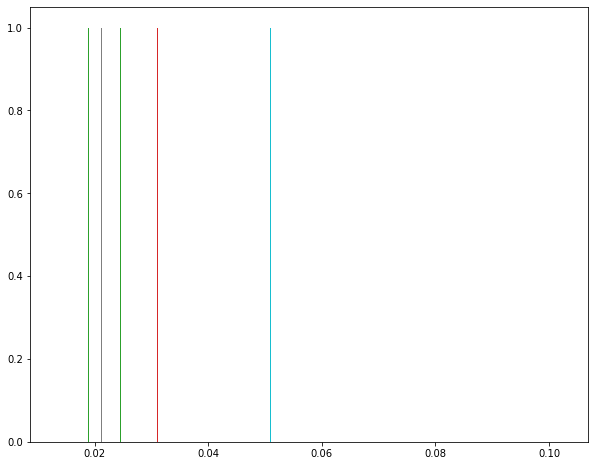

In [79]:
reconstructions = model.predict(data.normal_test_data) 
train_loss = tf.keras.losses.mae(reconstructions, data.normal_test_data)
plt.hist(train_loss, bins=50)

In [80]:
def Threshold (train_loss) : 
  threshold = np.mean(train_loss) + 2*np.std(train_loss)
  return threshold

In [81]:
threshold = Threshold (train_loss)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.03781251, 0.04117838, 0.04454426, 0.04791013, 0.051276  ,
        0.05464187, 0.05800774, 0.06137362, 0.06473949, 0.06810536,
        0.07147123, 0.0748371 , 0.07820297, 0.08156885, 0.08493472,
        0.08830059, 0.09166646, 0.09503233, 0.09839821, 0.10176408,
        0.10512995, 0.10849582, 0.11186169, 0.11522756, 0.11859344,
        0.12195931, 0.12532518, 0.12869105, 0.13205692, 0.1354228 ,
        0.13878867, 0.14215454, 0.14552041, 0.14888628, 0.15225215,
        0.15561803, 0.1589839 , 0.16234977, 0.16571564, 0.16908151,
        0.17244739, 0.17581326, 0.17917913, 0.182545  , 0.18591087,
        0.18927674, 0.19264262, 0.19600849, 0.19937436, 0.20274023,
        0.2061061 ]),
 <a list of 437 BarContainer objects>)

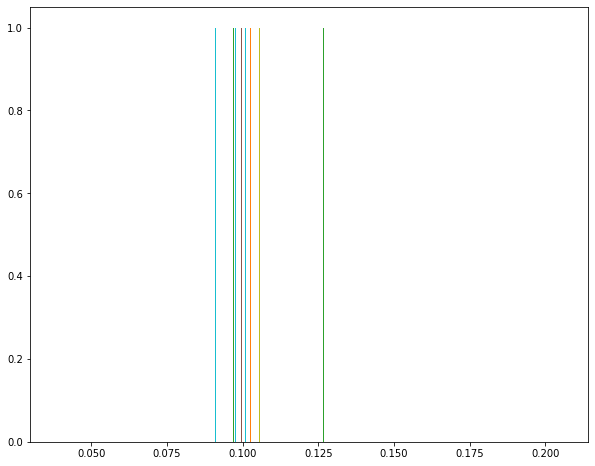

In [82]:
reconstructions_a = model.predict(data.anomaly_test_data) 
train_loss_a = tf.keras.losses.mae(reconstructions_a, data.anomaly_test_data)
plt.hist(train_loss_a, bins=50)


In [83]:
# hna khat héka séprateur bin anomaly w normal data 
def anomaly_normal_plot(train_loss,train_loss_a) : 
  plt.hist(train_loss, bins=50, label='normal')
  plt.hist(train_loss_a, bins=50, label='anomaly')
  plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
  plt.legend(loc='upper right')
  plt.show()

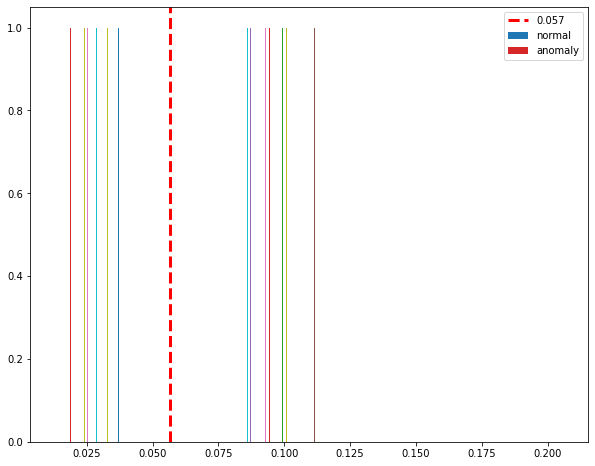

In [84]:
anomaly_normal_plot(train_loss,train_loss_a)

In [85]:
def model_accuracy (train_loss,train_loss_a , threshold) : 
  accuracy_healthy = (tf.math.count_nonzero(tf.math.less(train_loss, threshold)).numpy() ) / len(train_loss)
  accuracy_unhealthy = (tf.math.count_nonzero(tf.math.greater(train_loss_a, threshold)).numpy() ) / len(train_loss)
  return accuracy_healthy , accuracy_unhealthy 

In [86]:
accuracy_healthy , accuracy_unhealthy  = model_accuracy (train_loss,train_loss_a , threshold)
print ('The accuracy of predicting the healthy cardiac' , accuracy_healthy)
print ('The accuracy of predicting the unhealthy cardiac' , accuracy_unhealthy)

The accuracy of predicting the healthy cardiac 0.9715808170515098
The accuracy of predicting the unhealthy cardiac 0.7708703374777975



7. Auto Time Series 

When you create a predictor, you can either choose AutoML to let Amazon Forecast optimize the predictor for you, or you can manually choose a Forecast algorithm for your predictor. When you use AutoML, Forecast trains different models with your target time series, related time series, and item metadata. It then uses the model with the best accuracy metrics.

By default, Forecast evaluates predictors by averaging the Weighted Quantile Losses (wQL) of the 0.1 (P10), 0.5 (P50), and 0.9 (P90) quantiles. If you specify custom Forecast Types, Forecast uses the average losses of those forecast types. If you are using multiple backtest windows, Forecast uses the averages across all backtest windows. For hyperparameter optimization (HPO), Forecast uses the first backtest window to find the optimal hyperparameter values.

Unless you are certain that you want to use a specific algorithm to train a predictor, we recommend that you use AutoML. AutoML is more versatile and generally results in a more accurate predictor.

In [87]:
# Data to consider 
df = pd.read_csv('/tmp/aq/PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv', parse_dates = [['year', 'month', 'day', 'hour']],date_parser=convert_to_date, keep_date_col=True)
df = df [['year_month_day_hour','PM10','PM2.5']]
df.fillna(5,inplace=True)

__init__ (self,df) : Constructor of the class 

model (self,score_type,time_interval,non_seasonal_pdq,seasonality,model_type) : Construct the AutoMLmodel 

split_data (self,timestamp,condition_1,condition_2) : function to split the data into train and test based on  two conditions on the timestamp

fitting (self,ts_column,target) : fit the data 

cv_scores (self) : Perform cross validation on the different models in order to select the best one

results (self) : return a dictionnary containing all the results 

leader_board (self) : return a leader board in order to choose the best model 

predict (self)  : Perform the predictions 

In [88]:
class Auto_TS () : 
  def __init__ (self,df) : 
    self.df = df 
  def model (self,score_type,time_interval,non_seasonal_pdq,seasonality,model_type) : 
    self.model = auto_timeseries(score_type=score_type, time_interval=time_interval, non_seasonal_pdq=non_seasonal_pdq, seasonality=seasonality, model_type=model_type, verbose=2)
  def split_data (self,timestamp,condition_1,condition_2) : 
    self.train=self.df[(self.df[timestamp] >= condition_1 ) & (self.df[timestamp] <= condition_2)]
    self.test=self.df[(self.df[timestamp] > condition_2 )]
  def fitting (self,ts_column,target) : 
    self.model.fit(traindata=self.train, ts_column=ts_column, target=target, cv=3)
  def cv_scores (self) : 
    scores = self.model.get_cv_scores() 
    return scores 
  def results (self) : 
    results_dict = model.get_ml_dict()
    return results_dict
  def leader_board (self) : 
    leaderboard = self.model.get_leaderboard()
    return leaderboard
  def predict (self) : 
    predict = self.model.predict(self.test)
    return predict 


In [89]:
# Auto_ML = Auto_TS(df) 
# Auto_ML.model(score_type='rmse', time_interval='M', non_seasonal_pdq=(2,1,2), seasonality=True, model_type=['best'])
# Auto_ML.split_data ('year_month_day_hour','2012-01-01','2016-01-01')
# Auto_ML.fitting('year_month_day_hour','PM10')


In [90]:
# scores = Auto_ML.cv_scores()
# results = Auto_ML.results()
# leaderboard = Auto_ML.leader_board()
# prediction = Auto_ML.predict()

8. Reinforcement Learning Approches 

In [91]:
# df = pd.read_csv('/content/drive/MyDrive/Reinforcement-Learning-for-Trading-main/Reinforcement-Learning-for-Trading-main/data/gmedata.csv')
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)


In [92]:
# class RL_Forecasting () : 
#   def __init__(self,df) : 
#     self.df = df 
#   def environnement (self,environnement,frame_bound,window_size) : 
#     self.env = gym.make(environnement, df=self.df, frame_bound=frame_bound, window_size=window_size)
#   def build_environnement (self) : 
#     state = self.env.reset()
#     while True: 
#         action = self.env.action_space.sample()
#         n_state, reward, done, info = self.env.step(action)
#         if done: 
#             print("info", info)
#             break
            
#     plt.figure(figsize=(15,6))
#     plt.cla()
#     env.render_all()
#     plt.show()
#   def vectorizing_environnement (self,vectorizer) : 
#     self.env = vectorizer([lambda: self.env]) # vectorizer l'environnement 
#   def Agent_builder (self,policy) : # najmo na3mlo Extention mch bétharoura A2C
#     self.agent = A2C(policy, self.env, verbose=1) 
#   def model_fit (self,total_timesteps) : 
#     self.agent.learn(total_timesteps=total_timesteps)
#   def evaluation (self) : 
#     obs = self.env.reset()
#     while True: 
#         obs = obs[np.newaxis, ...]
#         action, _states = self.agent.predict(obs)
#         obs, rewards, done, info = self.env.step(action)
#         if done:
#             print("info", info)
#             break
#     plt.figure(figsize=(15,6))
#     plt.cla()
#     env.render_all()
#     plt.show() 

In [93]:
# rl_object = RL_Forecasting(df)
# rl_object.environnement('stocks-v0',(5,100),5)
# rl_object.build_environnement()
# rl_object.vectorizing_environnement(DummyVecEnv)
# rl_object.Agent_builder('MlpLstmPolicy')
# rl_object.model_fit(1000)
# rl_object.evaluation()

9. Classic Machine learning Approches 

One approch that may be efficient to use is to see the forecasting problem as a classic regression problem . The problem here is that in the classic approches the data set are assumped as iid (independent and identically distrbuted ) . Unlike the forecasting problems where we have dependence between the different observations . So here we risk that our models don't capture the trend / seasonality etc .... But it seems challanging to try this kind of approches .. Let's get more in detail

9.0 Imports

In [94]:
!pip install optuna

In [95]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import optuna 

9.1 Utils

here we have just a function to load the data .. nothing special 

In [96]:
def load (path) : 
  df = pd.read_csv(path)
  return df

In [97]:
df = load('../input/oil-price-prediction/Total_Data.csv') # if you want to work with flatten data 
df.head()

Unnamed: 0  Brent Oil Price $  Total_production  Total_Imports  \
0           0             101.01        68417.0990     41028.9659   
1           1             111.80        68564.7723     39526.3794   
2           2             117.36        67048.3280     41465.8816   
3           3             125.89        67224.1987     41090.5091   
4           4             116.73        66979.3286     40116.6853   

   Total_Exports  Total_INTAKE  
0     36220.0055   218824.1831  
1     37841.8210   217755.5908  
2     35865.1036   215655.0840  
3     36385.5678   215000.8380  
4     35708.4215   213736.2600

The data to consider here is about predicting the Brent Oil Price $ from the total_production , imports , total exports , intake 

9.2 Filling_Nans

Here a standard function to verify is there any missing value

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
def missing_values(df): 
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  f, ax = plt.subplots(figsize=(15, 6))
  plt.xticks(rotation='90')
  sns.barplot(x=missing_data.index, y=missing_data['Percent'])
  plt.xlabel('Features', fontsize=15)
  plt.ylabel('Percent of Missing Values', fontsize=15)
  plt.title('Percentage of Missing Data by Feature', fontsize=15)
  # missing_data.head()
  return (missing_data)

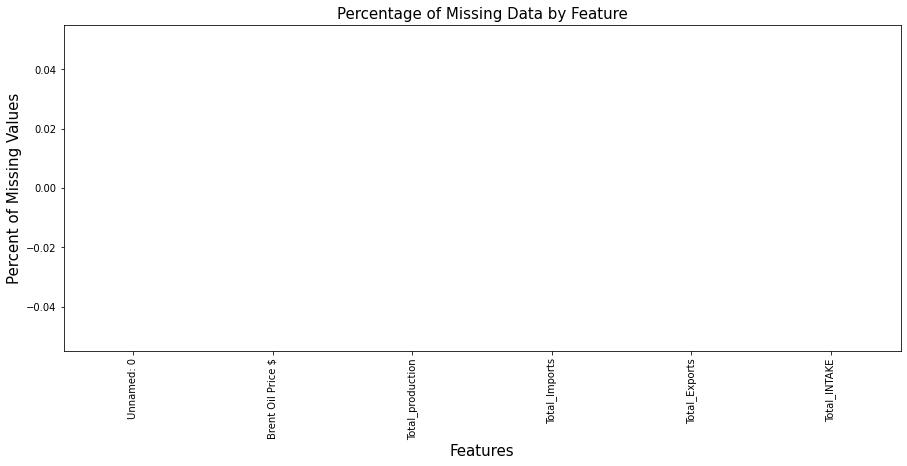

In [99]:
_  = missing_values(df) # Clean data 

9.3  Preprocess 

Here we get into the preprocess of the data we are going to remove the constant & unuseful features 

In [100]:
# from sklearn.feature_selection import VarianceThreshold
# def constant_features (df,threshold) :  #threshold : paramétre ta3 variance .... 
#     sel = VarianceThreshold(threshold=threshold)
#     sel.fit(df)  # fit finds the features with zero variance
#     to_drop = [x for x in df.columns if x not in df.columns[sel.get_support()]]
#     return to_drop 

In [101]:
# to_drop = constant_features (df,0) # constant features 


In [102]:
# def Unuseful_features(df):  
#   df.drop('Unnamed: 0',axis=1,inplace=True)
#   df.drop(to_drop,axis=1,inplace=True)
#   return df 

In [103]:
# df = Unuseful_features(df)

In [104]:
# from sklearn.model_selection import train_test_split
# def split(df):
#   train, test = train_test_split(df, test_size=0.2, random_state=25)
#   return train,test

In [105]:
# train,test = split(df)

9.4 Modeling

9.4.1 GridSearchCV

The GridSearchCV here serve to to tune the params of our model . We perform a full search on the best combinaison between different params . 

In [106]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV

# model = xgb.XGBRegressor()
# parameters = {'depth'         : [3,4,5,6], 
#                   'learning_rate' : [0.05, 0.1 , 0.15],      # les paramétres li t7éb tlawéj 3la a7san combinaison binéthom
#                   'iterations'    : [100 , 200 , 500 ]
#                  }
# cv = 2, 
# n_jobs=-1

In [107]:
# import numpy as np
# import pandas as pd
# from tqdm import tqdm
# from sklearn.model_selection import GridSearchCV
# class GridSearch :
#   def __init__(self,train,test,target) :
#     self.data = train
#     self.X_train = train.drop(target,axis=1)
#     self.y_train = train[target]
#     self.X_test , self.y_test = test.drop(target ,axis=1) , test[target]
#   def model (self,model) :
#     self.model = model
#   def parameters (self, parameters) :
#     self.parameters = parameters
#   def GridSearch (self) :
#     self.grid = GridSearchCV(estimator=self.model, param_grid = self.parameters, cv = 5, n_jobs=-1)
#   def Gridfit (self) :
#     self.grid.fit((self.X_train),(self.y_train))
#   def finalfit (self) :
#     self.grid.best_estimator_.fit((self.X_train),(self.y_train))
#   def predict(self):
#     self.pred = self.grid.best_estimator_.predict((self.X_test))
#     return (self.pred)
#   def score(self):
#     self.score = mean_absolute_error(self.y_test,self.pred)
#     return self.score

In [108]:
# def Full_prediction_process () : 
#   gridsearch = GridSearch(train,test,'Brent Oil Price $')
#   gridsearch.model(model)
#   gridsearch.parameters(parameters)
#   gridsearch.GridSearch()
#   gridsearch.Gridfit()
#   gridsearch.finalfit()
#   prediction = gridsearch.predict()
#   print ('The overall error is about ',gridsearch.score() )

In [109]:
# You can check it by your self i desactivate in order to get more rapid kernel
# import warnings
# warnings.filterwarnings('ignore')
# if __name__ == "__main__": 
#   Full_prediction_process () 

9.4.2 Optuna

Hyperparameters optimization is an integral part of working on data science projects. But the more parameters we have to optimize, the more difficult it is to do it manually. To speed up project development, we may want to automate this work.

In this part, we will explore Optuna. It is an open-source framework for efficient and automatic hyperparameter optimization. We will take a closer look at its components and optimization methods.

In [110]:
# def optuna_split(df,column):
#   data = df.drop(column,axis=1) 
#   y = df[column]
#   return data , y 

In [111]:
# data , y = optuna_split(df,'Brent Oil Price $')

In [112]:
# from sklearn.metrics import mean_squared_error
# import xgboost as xgb
# def objective(trial,data=data,target=y):
    
#     train_x, test_x, train_y, test_y = train_test_split(data , target, test_size=0.15,random_state=42)
#     param = {
#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02,0.05,0.1,0.5]),
#         'n_estimators': 4000,
#         'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
#         'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
#     }
#     model = xgb.XGBRegressor(**param)  
    
#     model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
#     preds = model.predict(test_x)
    
#     rmse = mean_squared_error(test_y, preds,squared=False)
    
#     return rmse

In [113]:
# import warnings
# warnings.filterwarnings('ignore')
# def optimizing_process () : 
#   study = optuna.create_study(direction='minimize')
#   study.optimize(objective, n_trials=50)
#   print('Number of finished trials:', len(study.trials))
#   print('Best trial:', study.best_trial.params)
#   return study.best_trial.params

In [114]:
# best_trial = optimizing_process()
# best_trial = {'lambda': 0.003080373437108122, 'alpha': 0.0549978720799555, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.1,'max_depth': 5, 'random_state': 24, 'min_child_weight': 3}


In [115]:
# def final_split(data,y) : 
#   X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2,random_state=42)
#   return X_train, X_test, y_train, y_test
# X_train, X_test, y_train, y_test = final_split(data,y)

In [116]:
# def best_model(best_trial):
#   model = xgb.XGBRegressor(**best_trial)  
#   return model
# model = best_model(best_trial)
# def best_model_fit(model , X_train, X_test, y_train, y_test) : 
#   model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
#   return model 
# model = best_model_fit(model , X_train, X_test, y_train, y_test)
# def predict(model) : 
#   y_pred = model.predict(X_test)
#   return y_pred 
# y_pred = predict(model)

In [117]:
# from sklearn.metrics import mean_absolute_error
# mean_absolute_error(y_test, y_pred)

9.4.3 KFold

Normally in a machine learning process, data is divided into training and test sets; the training set is then used to train the model and the test set is used to evaluate the performance of a model. However, this approach may lead to variance problems. In simpler words, a variance problem refers to the scenario where our accuracy obtained on one test is very different to accuracy obtained on another test set using the same algorithm.

The solution to this problem is to use K-Fold Cross-Validation for performance evaluation where K is any number. The process of K-Fold Cross-Validation is straightforward. You divide the data into K folds. Out of the K folds, K-1 sets are used for training while the remaining set is used for testing. The algorithm is trained and tested K times, each time a new set is used as testing set while remaining sets are used for training. Finally, the result of the K-Fold Cross-Validation is the average of the results obtained on each set.

In [118]:
# remove_features = ['Brent Oil Price $']
# def features_utils (train):
#   features_columns = [col for col in train.columns if col not in remove_features]
#   return features_columns

In [119]:
# columns =  features_utils (train)
# Best_trial = {'lambda': 0.003080373437108122, 'alpha': 0.0549978720799555, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.1,'max_depth': 5, 'random_state': 24, 'min_child_weight': 3}


In [120]:
# from sklearn.model_selection import KFold
# import numpy as np
# import xgboost as xgb
# from sklearn.metrics import mean_absolute_error
# def KFold_train(train,test,target) : 
#   preds = np.zeros(test.shape[0])
#   kf = KFold(n_splits=5,shuffle=False)
#   rmse=[]  # list contains rmse for each fold
#   n=0
#   for trn_idx, test_idx in kf.split(train[columns],train[target]):
#       X_tr,X_val=train[columns].iloc[trn_idx],train[columns].iloc[test_idx]
#       y_tr,y_val=train[target].iloc[trn_idx],train[target].iloc[test_idx]
#       model = xgb.XGBRegressor(**Best_trial)
#       model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
#       preds+=model.predict(test[columns])/kf.n_splits
#       rmse.append(mean_absolute_error(y_val, model.predict(X_val)))
#       print(n+1,rmse[n])
#       n+=1
#   return preds

In [121]:
# preds = KFold_train(train,test,'Brent Oil Price $')

In [122]:
# from sklearn.metrics import mean_absolute_error
# mean_absolute_error(test['Brent Oil Price $'], preds)

10 . Graph Neural Networks 

Graph neural network (GNN) is an active frontier of deep learning, with a lot of applications, e.g., traffic speed/time prediction and recommendation system. In this Notebook, we will build our first GNN model to Epidemiological Forecasting
. We will run a spatio-temporal GNN model with example code from dgl library.

In [123]:
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+${CUDA}.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+${CUDA}.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+${CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.9.0+${CUDA}.html
# !pip install torch-geometric
# !pip install torch-geometric-temporal

In the next steps we will define the recurrent graph neural network architecture used for solving the supervised task. The constructor defines a DCRNN layer and a feedforward layer. It is important to note that the final non-linearity is not integrated into the recurrent graph convolutional operation. This design principle is used consistently and it was taken from PyTorch Geometric. Because of this, we defined a ReLU non-linearity between the recurrent and linear layers manually. The final linear layer is not followed by a non-linearity as we solve a regression problem with zero-mean targets.

PS : Just for the purpose of having a quick notebook and not a slow one and because the notebook is too long i will cancel this code because the install of pytorch geometric the framework on which we are working is extremly slow . Thank you very much for being comprehensive 

In [124]:
# from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
# from torch_geometric_temporal.signal import temporal_signal_split
# from tqdm import tqdm

In [125]:
# class CFG : 
#   loader = ChickenpoxDatasetLoader()
#   node_features = 4 
#   lr = 0.01 


In [126]:
# import torch
# import torch.nn.functional as F
# from torch_geometric_temporal.nn.recurrent import DCRNN

# class RecurrentGCN(torch.nn.Module):
#     def __init__(self, node_features):
#         super(RecurrentGCN, self).__init__()
#         self.recurrent = DCRNN(node_features, 32, 1)
#         self.linear = torch.nn.Linear(32, 1)

#     def forward(self, x, edge_index, edge_weight):
#         h = self.recurrent(x, edge_index, edge_weight)
#         h = F.relu(h)
#         h = self.linear(h)
#         return h

In [127]:
# class GNN () : 

#   def __init__(self,loader) : 
#     self.loader = loader 
#   def  getting_data_set (self) : 
#     self.dataset = self.loader.get_dataset()
#   def getting_train_test (self) : 
#     self.train_dataset, self.test_dataset = temporal_signal_split(self.dataset, train_ratio=0.2)
#   def model (self,node_features) : 
#     self.model = RecurrentGCN(node_features = node_features)
#   def optimizer (self,lr) : 
#     self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
#   def train () : 
#     self.model.train()
#     for epoch in tqdm(range(200)):
#         cost = 0
#         for time, snapshot in enumerate(self.train_dataset):
#             y_hat =self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
#             cost = cost + torch.mean((y_hat-snapshot.y)**2)
#         cost = cost / (time+1)
#         cost.backward()
#         self.optimizer.step()
#         self.optimizer.zero_grad()

11. Apach Spark

All the cases that we was about to prepare where for Univariate Time Series ... Now let's extend a bit and go for the multivariate Time Series using Apach Spark and Facebook Prophet 

Based on how much upvote and comments I get i will continue to comment this notebook ... If I get at least Silver medal . I need you support . 

In [128]:
# !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null 
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"  
# !update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

In [129]:
# !java -version
# !pip install pyspark
# !pip install pyarrow==0.15.1
# !pip install fbprophet


In [130]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from fbprophet import Prophet

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

# from pyspark.sql import SparkSession
# import pyspark
# from pyspark.sql.types import *

# result_schema =StructType([
#   StructField('ds',TimestampType()),
#   StructField('store_id',IntegerType()),
#   StructField('y',DoubleType()),
#   StructField('yhat',DoubleType()),
#   StructField('yhat_upper',DoubleType()),
#   StructField('yhat_lower',DoubleType())
#   ])

In [131]:
# # Data To consider
# df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/weekly_sales_data.csv')
# df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
# df = df.set_index('date')


In [132]:
# class Apach_Spark () : 
#   def __init__ (self,df) : 
#     self.df = df
#     self.spark = SparkSession.builder.master('local').getOrCreate()
#   def create_data_frame(self) : 
#     self.sdf = self.spark.createDataFrame(self.df)
#   def print_schema (self) : 
#     self.sdf.printSchema()
#   def counting (self) : 
#     self.sdf.count()
#   def groupby  (self) : 
#     self.sdf.select(['store_id']).groupBy('store_id').agg({'store_id':'count'}).show()
#   def temp_view (self) : 
#     self.sdf.createOrReplaceTempView("sales")
#   def count_store (self) : 
#     self.spark.sql("select store_id, count(*) from sales group by store_id order by store_id").show()
#   def prepare_ds_y (self,sql) : 
#     self.spark.sql(sql).show()
#   def get_paritions (self) : 
#     num = self.sdf.rdd.getNumPartitions()
#     return num 
#   def store_part (self,sql) : 
#     self.store_part = (self.spark.sql( sql ).repartition(self.spark.sparkContext.defaultParallelism, ['store_id'])).cache()
#   def explain (self) : 
#     explain = self.store_part.explain()
#     return explain



In [133]:
# sql = 'SELECT store_id, date as ds, sum(sales) as y FROM sales GROUP BY store_id, ds ORDER BY store_id, ds'

# apach = Apach_Spark(df) 
# apach.create_data_frame()
# apach.print_schema()
# apach.counting()
# apach.groupby()
# apach.temp_view()
# apach.count_store()
# # apach.prepare_ds_y(sql)
# num = apach.get_paritions()
# # apach.store_part(sql)
# # explain = apach.explain()

Upvote me .. And i'll finish the comments and code ... 
Have a nice day

In [134]:
# from pyspark.sql.functions import pandas_udf, PandasUDFType

# @pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
# def forecast_sales( store_pd ):

#   model = Prophet(interval_width=0.95,seasonality_mode = 'multiplicative', weekly_seasonality=True, yearly_seasonality=True)

#   model.fit( store_pd )

#   future_pd = model.make_future_dataframe(
#     periods=5, 
#     freq='w'
#     )
  
#   forecast_pd = model.predict( future_pd )  
  
#   f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
#   st_pd = store_pd[['ds','store_id','y']].set_index('ds')
  
#   results_pd = f_pd.join( st_pd, how='left' )
#   results_pd.reset_index(level=0, inplace=True)
  
#   results_pd['store_id'] = store_pd['store_id'].iloc[0]

#   return results_pd[ ['ds', 'store_id','y', 'yhat', 'yhat_upper', 'yhat_lower'] ]

In [135]:
# from pyspark.sql.functions import current_date

# results = (
#   store_part
#     .groupBy('store_id')
#     .apply(forecast_sales)
#     .withColumn('training_date', current_date() )
#     )
# final_df = results.toPandas()
# final_df=final_df.set_index('ds')


In [136]:
# final_df.query('store_id==44')[['y','yhat']].plot()
